# Enunciado: Una noche en el casino
En un casino un jugador dispone de 30 fichas y decide jugar una noche a la ruleta.

La ruleta estándar contiene 37 ranuras, numeradas del 0 al 36. Entre los números del 1 al 10 y del 19 al 28, los números pares van en rojo y los impares en negro. Entre los números del 11 al 18 y del 29 al 36, los números pares van en negro y los impares en rojo. El 0 es verde.

Las probabilidades de pago vienen determinadas por la posibilidad de que la bola en aterrice en la ranura seleccionada. Sin embargo, las probabilidades solamente tienen en cuenta las 36 ranuras negras y rojas numeradas y no la ranura verde del
0.Por ejemplo, si apuestas a un solo número tienes una posibilidad entre 37 (1/37) de acertar, y 36 posibilidades de 37 (36/37) de no acertar. Sin embargo, la cuota paga a 35:1, no a 36:1. La ranura del 0 es lo que se denomina “margen de la casa” (house edge), es decir el dinero que el casino espera recibir.

El jugador puede realizar las siguientes apuestas, con los premios correspondientes:
* Pagos 1:1. Los pagos 1:1 son apuestas que te ofrecen una devolución de dinero igualada. Por ejemplo, si apuestas una ficha y aciertas ganas 1 ficha más la ficha apostada. Los tres pagos más comunes 1:1 son los de a favor del rojo, del negro, de par/impar o a favor de un número alto o bajo (1-18 o 19-36).
* Pagos 2:1. Apostar a una serie de doce números (docena). Véanse en el tablero los tres espacios de apuesta para las seis docenas por las que se puede apostar (por filas y por columnas).
* Pagos 5:1. Apostar en series de seis números, colocando las fichas en el lateral de la mesa entre dos filas, significa que estas apostando a los tres números de ambas filas.
* Pagos 8:1. Apostar en una serie de cuatro números, colocando las fichas en el medio de cuatro números.
* Pagos 11:1. Apostar en una fila de tres números, colocando las fichas en el lateral de la tabla junto a una fila.
* Pagos 17:1. Apostar a un par de números, vertical u horizontal, colocando la ficha entre los dos números elegidos.
*  Pagos 35:1. Para ganar un pago 35:1, tendrás que apostar a un solo número.

El jugador siempre va a apostar una ficha y se retira cuando se queda sin fichas o cuando alcanza las 150.

Se estima que el número máximo de partidas que se pueden jugar en una noche es de 50.

Partiendo del planteamiento del problema anterior se deberán resolver las siguientes cuestiones: 
1. Si decide apostar al azar (de forma equiprobable en entre los distintos tipos de apuestas):
    
    a)  ¿Qué proporción de noches a lo largo de un mes se ha retirado por quedarse sin dinero?
    
    b) ¿Cuál es el número de fichas con las que ha finalizado las noches de ese mes y cómo se distribuye (representar el histograma)?
    
    c) ¿Cuál es el número medio de partidas jugadas antes de retirarse por quedarse sin dinero?
    
    
2.  Si analizamos el problema a largo plazo, jugando partidas indefinidamente, y empezando con 30 fichas ¿cuál es la probabilidad de que me quede sin dinero? ¿y la de que termine con 150 fichas?


3.  ¿Con qué probabilidad debería jugar a cada una de las partidas para que el beneficio medio de cada noche sea máximo? Utilícese la metaheurística recocido simulado.


## 0.  Pasos previos

### Cargar librerías y funciones necesarias

In [1]:
import transition_matrix as tm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import termometro as trm
from random import randrange
import numpy.random as rnd
from numpy.linalg import matrix_power
print("Se han cargado todas las librerias necesarias")

Se han cargado todas las librerias necesarias


In [2]:
gambling_random = np.random
gambling_random.seed(42)

In [3]:
%matplotlib inline
plt.style.use('seaborn-whitegrid')
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

### Modelización del enunciado
En esta sección vamos a modelar los diferentes elementos que componen nuestro problema. 
* Juego de la ruleta: probabilidades de ganar cierta apuesta de la ruleta y beneficio obtenido

In [4]:
bets = [(1, float(18 / 37)), # Pagos 1:1.
        (2, float(12 / 37)), # Pagos 2:1.
        (5, float(6 / 37)),  # Pagos 5:1.
        (8, float(4 / 37)),  # Pagos 8:1
        (11, float(3 / 37)), # Pagos 11:1.
        (17, float(2 / 37)), # Pagos 17:1.
        (35, float(1 / 37))] # Pagos 35:1.

* Probabilidades de realizar las apuestar anteriormente realizadas, son probabilidades equiprobables. A continuación el algoritmio SA se encargará de buscar el vector de probabilidades óptimo. 

In [5]:
p_bets_eq = [float(1/len(bets))]*len(bets)
p_bets_eq

[0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285]

* Límite de partidas y fichas: 

In [6]:
LEAVE_WITH_MIN = 0 # Mínimo número de fichas con las que el jugador se retira
LEAVE_WITH_MAX = 150 # Máximo número de fichas con las que el jugador se retira
NUM_GAMES = 50 # Número máximo de partidas que puede jugar un jugador
INITIAL_CHIPS = 30 # Número de fichas iniciales con las que comienza a jugar
DAYS = 30 # Número de días que el jugador va a ir a jugara a la ruleta

### Construir la matriz de transición

Una cadena es un proceso en tiempo discreto en el que una variable aleatoria $X_n$ va cambiando con el paso del tiempo. Las
cadenas de Markov tienen la propiedad de que la probabilidad de que $X_n = j$ sólo depende
del estado inmediatamente anterior del sistema: $X_n−1$. Cuando en una cadena dichas
probabilidades no dependen del tiempo en que se considere, $n$, $P(X_n = j | X-{n−1} = i)$

A continuación vamos a construir la cadena de Markov haciendo uso de la función `create_transition_matrix` que nosotros mismos hemos implementado. Esta mátriz se construye básandonos en el enunicado anteriormente comentado y en las propiedades de la cadena de Markov: 
$$
T = [p_{ij}] = \begin{bmatrix}
p_{1,1} & p_{1,2}  & \cdots  & p_{1,m} \\ 
p_{2,1} & p_{2,2} & \cdots & p_{2,m}\\ 
\vdots & \vdots & \ddots &  \cdots \\ 
p_{m,1} & p_{m,2}  & \cdots  &  p_{m,m}
\end{bmatrix}
$$

donde $p_{ij}$ es la probabilidad de ir del estado $i$ al $j$. En nuestro caso, un estado representa la cantidad de fichas que nuestro jugador tiene en ese momento. La probabilidad $p_{ij}$ es la probabilidad con la que el jugador pasa de tener $i$ a $j$ fichas. Cada una de las probabilidades se calcula de la siguiente manera: 

$P(probabilidad \  de\  realizar\  esta \ apuesta | probabilidad \ de\  ganar\  la\  apuesta)$

La matriz de transición se construye sabiendo los estados (en este caso el valor máximo y mínimo de fichas que puede alcanzar el jugador), las probabilidades de realizar las apuestas y las probabilidades de ganar la apuesta realizada. 

In [7]:
matrix = tm.create_transition_matrix(LEAVE_WITH_MIN,LEAVE_WITH_MAX, bets, p_bets_eq)

Vamos a visualizar la matriz creada por medio de la libreria pandas y añadiendo un vector de filas y columnas que representan los estados del problema, es decir, las fichas que tiene el jugador en cada momento. 

In [8]:
df = pd.DataFrame(matrix)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.822394,0.000000,0.069498,0.046332,0.000000,0.000000,0.023166,0.000000,0.000000,0.015444,0.000000,0.000000,0.011583,0.000000,0.000000,0.000000,0.0,0.0,0.007722,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003861,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.822394,0.000000,0.069498,0.046332,0.000000,0.000000,0.023166,0.000000,0.000000,0.015444,0.000000,0.000000,0.011583,0.000000,0.000000,0.0,0.0,0.000000,0.007722,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.003861,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.822394,0.000000,0.069498,0.046332,0.000000,0.000000,0.023166,0.000000,0.000000,0.015444,0.000000,0.000000,0.011583,0.000000,0.0,0.0,0.000000,0.000000,0.007722,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.003861,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

### Funciones para la simulación
En esta sección se definen las funciones necesarias para llevar a cabo la simulación. 
Para llevar a cabo esta simulación se han implementado tres funciones:
* `simulate_game`: esta función recibe como parámetro el estado en el que se encuentra el jugador, es decir, el número de fichas actuales. El jugador entonces realiza una apuesta y se produce la tirada de la ruleta. En función del resultado el jugador recibe un número de fichas o pierda la que ha apostado. Esta transición de pasar de un número de fichas a otro número de fichas se realiza mediante la matriz de transición anteriormente implementada. 
* `simulate_night`: esta función simula todas las posibles partidas que se puedan realizar en una noche en el casino. Básicamente ejecuta el metodo `simulate_game` tantas veces como número máximo de veces pueda jugar el jugador. Además en este método se recopila información a cerca de la evolución del número de fichas a lo largo de la noche. 
* `simulate_num_days`: esta función simula todas los días en los que el jugador va al casino. 

In [10]:
def simulate_game(state, matrix, gambling_random):
    return gambling_random.choice(range(len(matrix[state])), p=matrix[state])

In [11]:
def simulate_night(matrix, gambling_random, NUM_GAMES, state):
    chips = []
    games = 0
    chips.append(state)
    for i in range(NUM_GAMES):
        chips.append(simulate_game(chips[-1], matrix, gambling_random))
        if chips[-2] != LEAVE_WITH_MIN: games +=1
    return chips, games
        

In [12]:
def simulate_num_days(matrix, gambling_random,NUM_GAMES, INITIAL_CHIPS, DAYS):
    return [simulate_night(matrix, gambling_random,NUM_GAMES, INITIAL_CHIPS) for i in range(DAYS)]

In [13]:
def simulate(matrix, gambling_random,NUM_GAMES, INITIAL_CHIPS, DAYS):
    simulation = simulate_num_days(matrix, gambling_random,NUM_GAMES, INITIAL_CHIPS, DAYS)
    chips = [simulation[i][0] for i in range(DAYS)]
    games = [simulation[i][1] for i in range(DAYS)]
    return simulation, chips, games

### Funciones auxiliares
En esta sección se encuentran las funciones auxiliares para desarrollar diferentes tareas: representación, manejo de datos, manejo de estructuras, visualización...

In [14]:
def plot_chips_evolution(chips):
    x = range(len(chips[0]))
    plt.figure(figsize=(15, 15))
    for i,y in enumerate(chips):
        plt.plot(x, y,linewidth=4.0,  marker='o')
    plt.axhline(y=INITIAL_CHIPS, color='black', linestyle='-')

In [15]:
def create_df(chips, games):
    final_chips = [x[-1] for x in chips]
    improvement = [((x/INITIAL_CHIPS)-1) for x in final_chips]
    benefit = [(x-INITIAL_CHIPS) for x in final_chips]
    days = list(range(1, DAYS+1))
    d = {'Day':days, 'Chips': final_chips, 'Games': games, 'Benefit': benefit, 'Improvement': improvement} 
    df = pd.DataFrame(d)
    return df

In [16]:
def plot_bar_graph(df, INITIAL_CHIPS):
    x = df['Day']
    y = df['Chips']
    mask1 = df['Chips'] < INITIAL_CHIPS
    mask2 = df['Chips'] >= INITIAL_CHIPS
    plt.figure(figsize=(20,10))
    plt.bar(x[mask1], y[mask1], color = 'red')
    plt.bar(x[mask2], y[mask2], color = 'blue')
    plt.axhline(y=INITIAL_CHIPS, color='black', linestyle='-')
    plt.xlabel("Días")
    plt.ylabel("Número de fichas")
    plt.show()

In [18]:
def show_results(df, INITIAL_CHIPS, LEAVE_WITH_MAX):
    print("Número de noches que el jugador perdió todas las fichas: " + str(np.count_nonzero(df['Chips']==0)))
    print("Porcentaje de noches que el jugador perdió todas las fichas: " + str(round((np.count_nonzero(df['Chips']==0)/DAYS)*100,2)) + "%")
    print("Número de noches que el jugador perdió fichas: " + str(np.count_nonzero(df['Chips']<INITIAL_CHIPS)))
    print("Porcentaje de noches que el jugador perdió fichas: " + str(round((np.count_nonzero(df['Chips']<INITIAL_CHIPS)/DAYS)*100,2)) + "%")
    print("Número de noches que el jugador salió igual del casino: " + str(np.count_nonzero(df['Chips']==INITIAL_CHIPS)))
    print("Porcentaje de noches que el jugador salió igual del casino: " + str(round((np.count_nonzero(df['Chips']==INITIAL_CHIPS)/DAYS)*100,2)) + "%")
    print("Número de noches que el jugador ganó fichas: " + str(np.count_nonzero(df['Chips']>INITIAL_CHIPS)))
    print("Porcentaje de noches que el jugador ganó fichas: " + str(round((np.count_nonzero(df['Chips']>INITIAL_CHIPS)/DAYS)*100,2)) + "%")
    print("Número de noches que el jugador se retiró alcanzando el máximo de fichas: " + str(np.count_nonzero(df['Chips']>=LEAVE_WITH_MAX)))
    print("Porcentaje de noches que el jugador se retiró alcanzando el máximo de fichas: " + str(round((np.count_nonzero(df['Chips']>=LEAVE_WITH_MAX)/DAYS)*100,2)) + "%")

## Ejercicio 1: Si decide apostar al azar:
###       a)  ¿Qué proporción de noches a lo largo de un mes se ha retirado por quedarse sin dinero?

Lo primero que vamos a hacer es ejecutar la simulación. Recordamos los parámetros, la probabilidad de realizar cada una de las posibles apuestas es equiprobable, el número máximo de partidas que se puede jugar una noche es 50, el jugador va a ir todos los días de un mes, es decir, 30 días, si el jugador alcanza 0 fichas o 150 o más se planta. Además, el jugador empieza cada noche con 30 fichas. 

In [17]:
LEAVE_WITH_MIN = 0
LEAVE_WITH_MAX = 150
NUM_GAMES = 50
INITIAL_CHIPS = 30
DAYS = 30

In [18]:
simulation, chips, games = simulate(matrix, gambling_random,NUM_GAMES, INITIAL_CHIPS, DAYS)
df = create_df(chips, games)

La simulación se ha realizado, veaos cual es el resultado obtenido a lo largo del mes: 

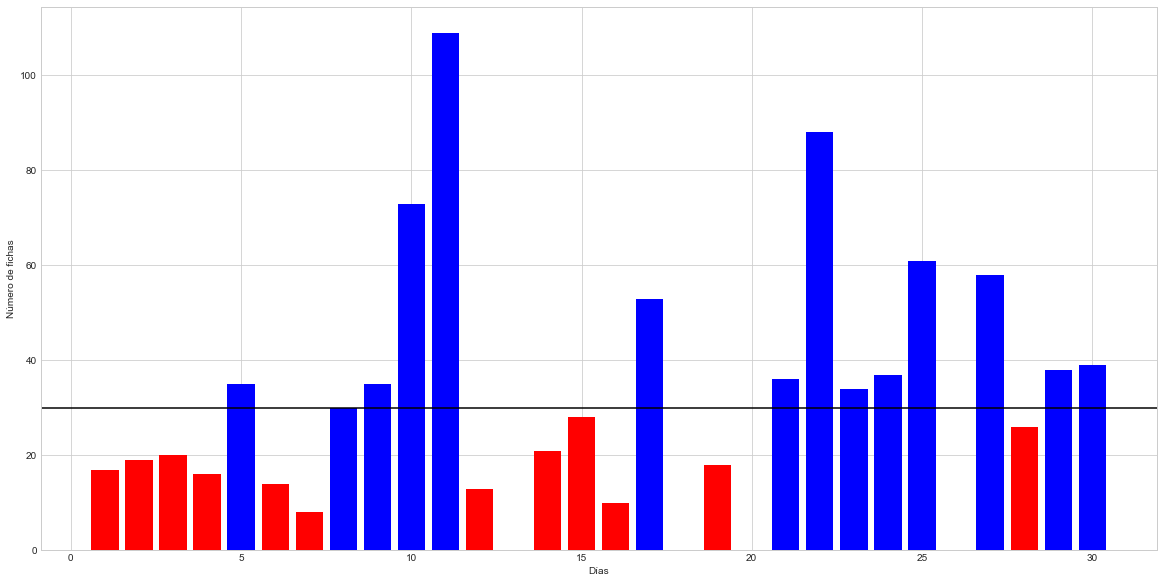

In [19]:
plot_bar_graph(df, INITIAL_CHIPS)

En el gráfico anterior se muestran en el eje x los diferentes días del mes. En el eje y se muestra el número de fichas con las que el jugador salio del casino cada uno de los días. La línea negra muestra el número de fichas con el que el jugador entró al casino. Las barras coloreadas de color rojo son los días malos de nuestro jugador en los cuales perdió fichas. Por otro lado, los días con barras azules son días en los que el jugador obtuvo beneficio. Si un día no muestra barra es por que el jugador se fue ese día sin ninguna ficha. 

Respondiendo a la pregunta, el número de noches en las que el jugador se ha tenido que retirar por que se ha quedado sin dinero es el siguiente: 

In [20]:
show_results(df, INITIAL_CHIPS, LEAVE_WITH_MAX)

Número de noches que el jugador perdió todas las fichas: 4
Porcentaje de noches que el jugador perdió todas las fichas: 13.33%
Número de noches que el jugador perdió fichas: 16
Porcentaje de noches que el jugador perdió fichas: 53.33%
Número de noches que el jugador salió igual del casino: 1
Porcentaje de noches que el jugador salió igual del casino: 3.33%
Número de noches que el jugador ganó fichas: 13
Porcentaje de noches que el jugador ganó fichas: 43.33%
Número de noches que el jugador se retiró alcanzando el máximo de fichas: 0
Porcentaje de noches que el jugador se retiró alcanzando el máximo de fichas: 0.0%


###        b) ¿Cuál es el número de fichas con las que ha finalizado las noches de ese mes y cómo se distribuye (representar el histograma)?

En el gráfico anterior se mostró cuales eran las fichas que nuestro jugador había sido capaz de llevarse a casa para cada uno de los días del mes. 
Vamos a aprovechar esta pregunta para visualizar la evolución de la cantidad de fichas que tuvo nuestro jugador a lo largo de cada uno de los días en el casino. 

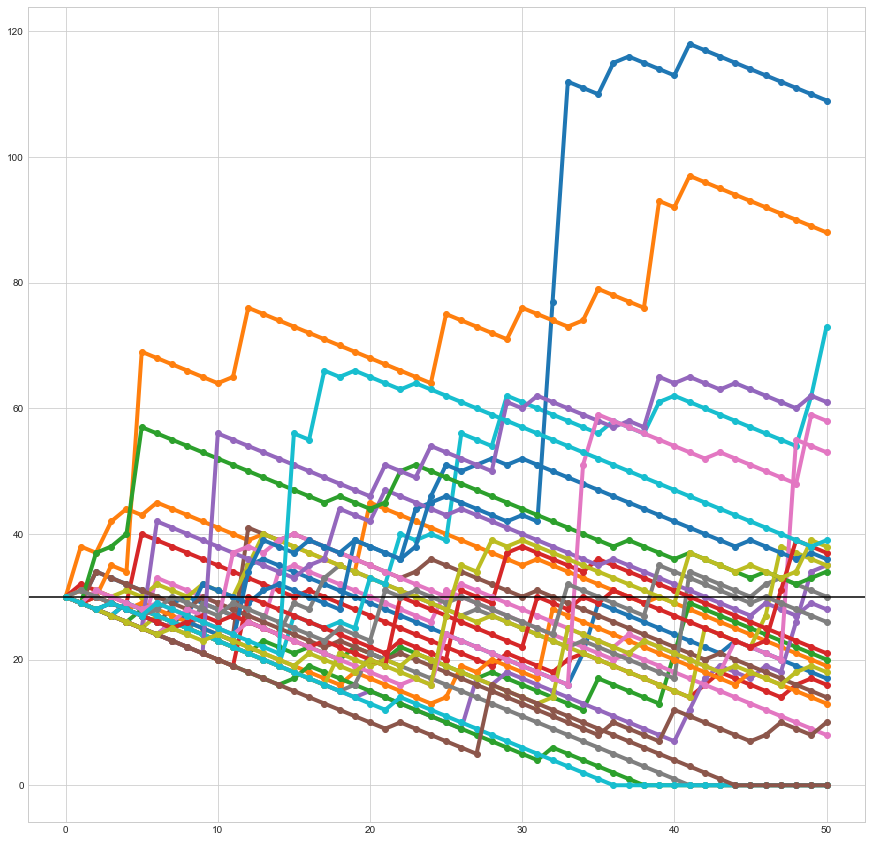

In [21]:
plot_chips_evolution(chips)

Por último, vamos a mostra rle histograma de frecuencia de la cantidad de fichas con las que le jugador es capaz de salir del casino a lo largo de un mes. 

(0, 157.4341804981768)

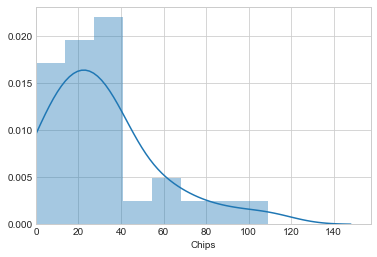

In [22]:
sns.distplot(df['Chips']);plt.xlim(0,None)

###           c) ¿Cuál es el número medio de partidas jugadas antes de retirarse por quedarse sin dinero?

In [23]:
ruined = df[df['Chips'] == 0]
ruined

,Day,Chips,Games,Benefit,Improvement
12,13,0,38,-30,-1.0
17,18,0,41,-30,-1.0
19,20,0,36,-30,-1.0
25,26,0,44,-30,-1.0


In [24]:
"El jugador se ha arruinado "+ str(ruined.shape[0]) +" veces, jugando de media " + str(round(ruined["Games"].mean(),2)) + " días antes de arruinarse."

'El jugador se ha arruinado 4 veces, jugando de media 39.75 días antes de arruinarse.'

####          Estadísticos de esta primera simulación
Aunque esta sección no estaba requerida en el enunicado de la memoria a continuación se muestran  diferentes estadísticos sencillos que pueden ayudarnos a comprender mejor el resultado de la simulación. 

In [25]:
df.describe()

,Day,Chips,Games,Benefit,Improvement
count,30.000000,30.000000,30.000000,30.000000,30.000000
mean,15.500000,31.200000,48.633333,1.200000,0.040000
std,8.803408,26.156558,3.718392,26.156558,0.871885
min,1.000000,0.000000,36.000000,-30.000000,-1.000000
25%,8.250000,14.500000,50.000000,-15.500000,-0.516667
50%,15.500000,27.000000,50.000000,-3.000000,-0.100000
75%,22.750000,37.750000,50.000000,7.750000,0.258333
max,30.000000,109.000000,50.000000,79.000000,2.633333


### Análisis de los resultados en media

In [26]:
LEAVE_WITH_MIN = 0
LEAVE_WITH_MAX = 150
NUM_GAMES = 50
INITIAL_CHIPS = 30
DAYS = 30

In [27]:
months = [simulate(matrix, gambling_random,NUM_GAMES, INITIAL_CHIPS, DAYS)  for i  in range(1000)]

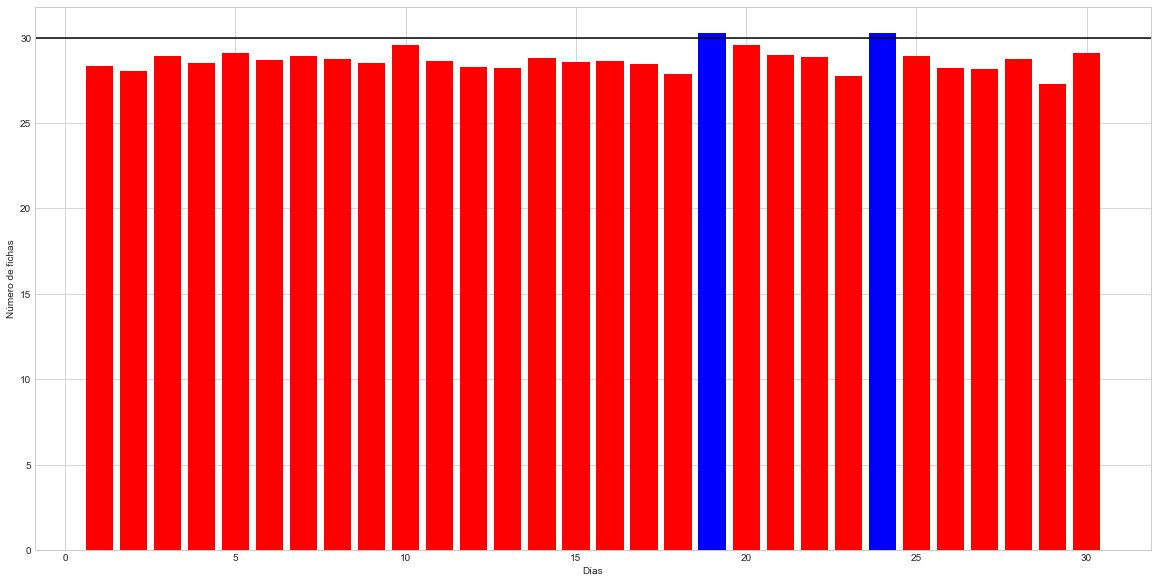

In [28]:
simulations = []
chips = []
games = []
for s, c, g  in months:
    simulations.append(s)
    chips.append(c)
    games.append(g)
    
chips = np.array(chips)
chips_avg = chips.sum(0)/len(chips)
games = np.array(games)
games_avg = games.sum(0)/len(games)
df = create_df(chips_avg, games_avg)
plot_bar_graph(df, INITIAL_CHIPS)

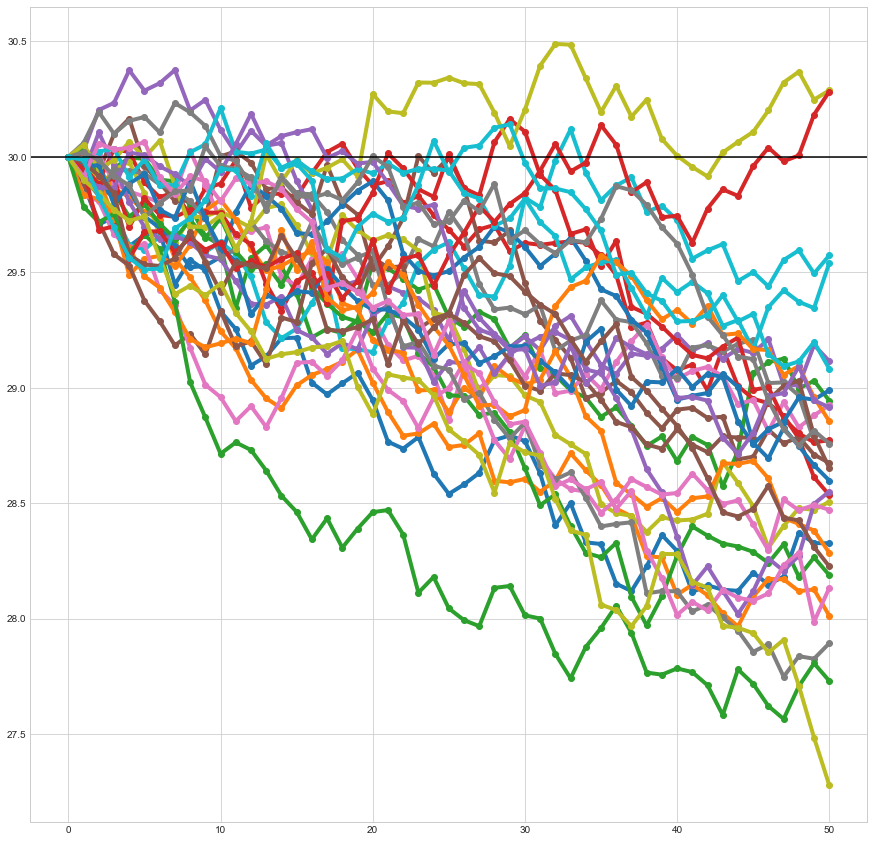

In [29]:
plot_chips_evolution(chips_avg)

(0, 31.515323668342266)

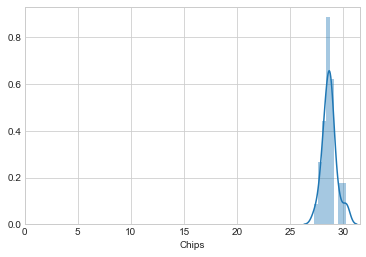

In [30]:
sns.distplot(df['Chips']);plt.xlim(0,None)

### Análisis de la distribución
En esta ocasión vamos a olvidarnos del problema en si y vamos a estudiar como se comporta la distribución de las fichas obtenidas al final devarias noches


(0, 149.99743438306857)

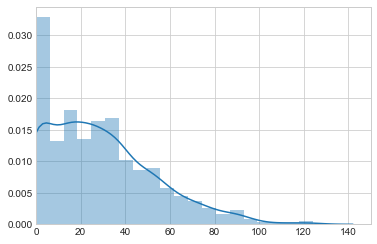

In [64]:
bet_eq_fc = []
for i in range (1000):
    _, chips_eq, _ = simulate(matrix, gambling_random,NUM_GAMES, INITIAL_CHIPS, 1)
    matrix = tm.create_transition_matrix(LEAVE_WITH_MIN,LEAVE_WITH_MAX, bets, bet_al)
    bet_eq_fc.append(chips_eq[0][-1])

sns.distplot(bet_eq_fc);plt.xlim(0,None)

In [65]:
pd.DataFrame(bet_eq_fc).describe() 

,0
count,1000.000000
mean,29.048000
std,23.895286
min,0.000000
25%,11.000000
50%,26.000000
75%,43.000000
max,124.000000


## Ejercicio 2:    Si analizamos el problema a largo plazo, jugando partidas indefinidamente, y empezando con 30 fichas ¿cuál es la probabilidad de que me quede sin dinero? ¿y la de que termine con 150 fichas?

In [43]:
LEAVE_WITH_MIN = 0
LEAVE_WITH_MAX = 150
NUM_GAMES = 4000
INITIAL_CHIPS = 30
DAYS = 1000

In [44]:
simulation, chips, games = simulate(matrix, gambling_random,NUM_GAMES, INITIAL_CHIPS, DAYS)
df = create_df(chips, games)

La simulación se ha realizado, veaos cual es el resultado obtenido a lo largo del mes: 

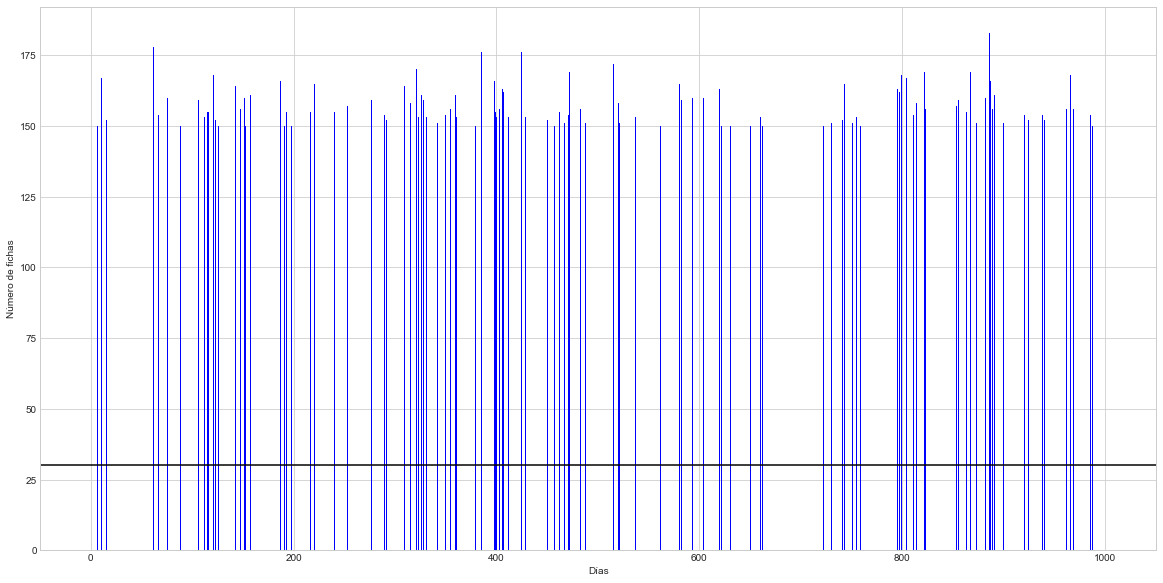

In [45]:
plot_bar_graph(df, INITIAL_CHIPS)

In [46]:
show_results(df, INITIAL_CHIPS, LEAVE_WITH_MAX)

Número de noches que el jugador perdió todas las fichas: 860
Porcentaje de noches que el jugador perdió todas las fichas: 86.0%
Número de noches que el jugador perdió fichas: 860
Porcentaje de noches que el jugador perdió fichas: 86.0%
Número de noches que el jugador salió igual del casino: 0
Porcentaje de noches que el jugador salió igual del casino: 0.0%
Número de noches que el jugador ganó fichas: 140
Porcentaje de noches que el jugador ganó fichas: 14.0%
Número de noches que el jugador se retiró alcanzando el máximo de fichas: 140
Porcentaje de noches que el jugador se retiró alcanzando el máximo de fichas: 14.0%


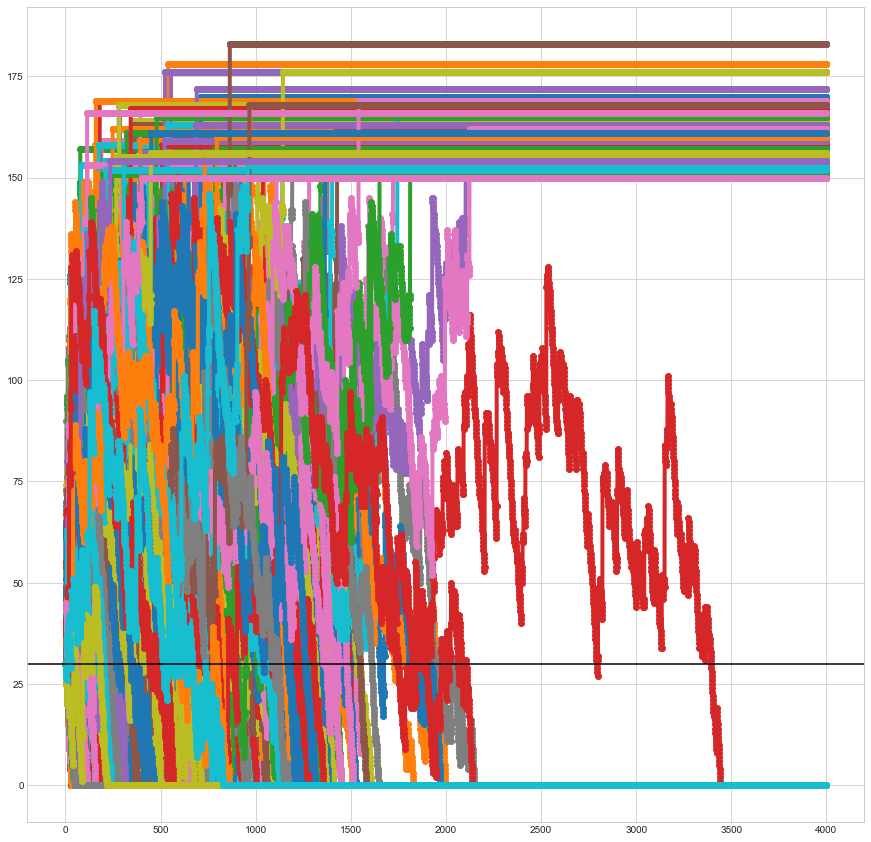

In [47]:
plot_chips_evolution(chips)

In [48]:
df.describe()

,Day,Chips,Games,Benefit,Improvement
count,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000
mean,500.500000,22.01600,803.490000,-7.98400,-0.266133
std,288.819436,54.65564,1332.793434,54.65564,1.821855
min,1.000000,0.00000,30.000000,-30.00000,-1.000000
25%,250.750000,0.00000,80.000000,-30.00000,-1.000000
50%,500.500000,0.00000,175.500000,-30.00000,-1.000000
75%,750.250000,0.00000,615.500000,-30.00000,-1.000000
max,1000.000000,183.00000,4000.000000,153.00000,5.100000


### Cálculo de la matriz estacionaria

In [54]:
matrix = tm.create_transition_matrix(LEAVE_WITH_MIN,LEAVE_WITH_MAX, bets, p_bets_eq)
elevate_matrix_n = 10**9
chips_start = 30
matrix_future = matrix_power(np.array(matrix), elevate_matrix_n)
print("El porcentaje exacto de perder todas las fichas, empezando con %s es: %s" %(chips_start, matrix_future[chips_start][0]))
print("Matriz elevada a %s"%elevate_matrix_n)
pd.DataFrame(matrix_future).head()

El porcentaje exacto de perder todas las fichas, empezando con 30 es: 0.8618635964960594
Matriz elevada a 1000000000


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184
0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.995705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000619,0.000482,0.000399,0.000350,0.000302,0.000254,0.000224,0.000194,0.000164,0.000146,0.000128,0.000110,0.000100,0.000091,0.000082,0.000073,0.000064,0.000055,0.000052,0.000048,0.000045,0.000042,0.000039,0.000036,0.000033,0.00003,0.000027,0.000024,0.000021,0.000018,0.000015,0.000012,0.000009,0.000006,0.000003
2,0.991390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001241,0.000967,0.000799,0.000702,0.000606,0.000510,0.000449,0.000389,0.000329,0.000292,0.000256,0.000220,0.000201,0.000183,0.000164,0.000146,0.000128,0.000110,0.000103,0.000097,0.000091,0.000085,0.000078,0.000072,0.000066,0.00006,0.000054,0.000048,0.000042,0.000036,0.000030,0.000024,0.000018,0.000012,0.000006
3,0.987055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

## Ejercicio 3:  ¿Con qué probabilidad debería jugar a cada una de las partidas para que el beneficio medio de cada noche sea máximo? Utilícese la metaheurística recocido simulado.


###  Elementos del algoritmo

#### Constructivo

In [37]:
def inicializador_aleatorio(bets):
    x = []
    for i in range(len(bets)):
        x.append(randrange(100))
    suma = np.sum(x)
    x = x/suma
    return x

def inicializador_equiprobable(bets):
    return [float(1/len(bets))]*len(bets)

#### Estructura de Vecindad

In [38]:
def vecindad(x, delta=0.3, c=3):
    for i in range(c):
        j = randrange(len(x))
        x[j] = x[j] + delta
    suma = np.sum(x)
    x = x/suma
    return x

#### Probailidad de Aceptación

In [39]:
def probabilidad_aceptacion(y, y_nuevo, temperatura):
    # si mejora la solución actual se acepta siempre
    if y_nuevo > y:
        return 1
    # en caso contrario, la aceptación dependerá de la temperatura,
    # a medida que avanza el problema menor temperatura, menor probabilidad de aceptación
    else:
        probabilidad = np.exp(- (y - y_nuevo) / temperatura)
        return probabilidad

#### Función Objetivo

In [112]:
def fo(chips, games):
    final_chips = [x[-1] for x in chips]
    return sum(final_chips) / len(final_chips) 

def fo_v2(chips, games, k2=0.1):
    final_chips = [x[-1] for x in chips]
    return  (sum(final_chips)/ len(final_chips)) + k2 * (sum(games) / len(games))

### Ejecución del algoritmo

In [146]:
def recocido_simulado(funcion, vecindad, x_inicial, probabilidad_aceptacion, max_iteraciones, informacion, gambling_random,NUM_GAMES, INITIAL_CHIPS, DAYS, bets, LEAVE_WITH_MIN, LEAVE_WITH_MAX):
    T = 1
    x = x_inicial
    matrix = tm.create_transition_matrix(LEAVE_WITH_MIN,LEAVE_WITH_MAX, bets, x)
    _, chips, games = simulate(matrix, gambling_random,NUM_GAMES, INITIAL_CHIPS, DAYS)
    y = funcion(chips, games)
    valores_x, valores_y = [x], [y]
    valores_t = []
    for iteracion in range(max_iteraciones+1):
        estado = iteracion / float(max_iteraciones)
        #T = trm.get_temperatura(iteracion=iteracion, descanso=100, temperatura_actual=T)
        T = trm.get_temperatura(estado)
        #T = trm.get_temperatura(temperatura_actual=T, beta = 0.2)
        valores_t.append(T)
        x_vecina = vecindad(x.copy())
        matrix = tm.create_transition_matrix(LEAVE_WITH_MIN,LEAVE_WITH_MAX, bets, x_vecina)
        _, chips, games = simulate(matrix, gambling_random,NUM_GAMES, INITIAL_CHIPS, DAYS)
        y_vecina = funcion(chips, games)
        if informacion == 1:
            print(
                "Iteracion {:>2}/{:>2} : T = {:>4.3g}, y = {:>4.3g}, y_vecina = {:>4.3g}".format(
                    iteracion, max_iteraciones, T, y, y_vecina))
        if probabilidad_aceptacion(y, y_vecina, T) > rnd.random():
            x, y = x_vecina, y_vecina
        valores_x.append(x)
        valores_y.append(y)
    return x, valores_y[-1], valores_x, valores_y, valores_t

In [129]:
LEAVE_WITH_MIN = 0
LEAVE_WITH_MAX = 150
NUM_GAMES = 50
INITIAL_CHIPS = 30
DAYS = 30
gambling_random = np.random
gambling_random.seed(42)

### Ajuste de parámetros

#### Constructivo
Se van a comparar los métodos de construcción de soluciones equiprobables y aleatorias. Para ello, se van a construir un número de soluciones determinada y a comprar los resultados de la simulación. 

In [93]:
bet_eq_fc = []
bet_al_fc = []
print("[", end = '')
for i in range (10000):
    bet_eq = inicializador_equiprobable(bets)
    bet_al = inicializador_aleatorio(bets)
    matrix = tm.create_transition_matrix(LEAVE_WITH_MIN,LEAVE_WITH_MAX, bets, bet_eq)
    _, chips_eq, _ = simulate(matrix, gambling_random,NUM_GAMES, INITIAL_CHIPS, 1)
    matrix = tm.create_transition_matrix(LEAVE_WITH_MIN,LEAVE_WITH_MAX, bets, bet_al)
    _, chips_al, _ = simulate(matrix, gambling_random,NUM_GAMES, INITIAL_CHIPS, 1)
    bet_eq_fc.append(chips_eq[0][-1])
    bet_al_fc.append(chips_al[0][-1])
    if i % 1000 == 0: print("/", end = '')
print("]")

plt.hist(bet_eq_fc, alpha=0.5, label='Equiprobable')
plt.hist(bet_al_fc, alpha=0.5, label='Aleatorio')
plt.legend(loc='upper right')
plt.show()

[/

KeyboardInterrupt: 

In [ ]:
dic = {"Equiprobable": bet_eq_fc, "Aleatorio": bet_al_fc}
pd.DataFrame(dic,).describe() 

### Visualización de los resultados del algoritmo

In [151]:
gambling_random = np.random
gambling_random.seed(42)
x, y, valores_x, valores_y, valores_t = recocido_simulado(fo, vecindad, inicializador_aleatorio(bets), probabilidad_aceptacion,10000,1,gambling_random, NUM_GAMES, INITIAL_CHIPS, DAYS, bets, LEAVE_WITH_MIN, LEAVE_WITH_MAX)

Iteracion  0/10000 : T =    1, y = 30.9, y_vecina = 26.6
Iteracion  1/10000 : T =    1, y = 30.9, y_vecina = 25.6
Iteracion  2/10000 : T =    1, y = 30.9, y_vecina = 31.2
Iteracion  3/10000 : T =    1, y = 31.2, y_vecina = 22.6
Iteracion  4/10000 : T =    1, y = 31.2, y_vecina = 20.2
Iteracion  5/10000 : T =    1, y = 31.2, y_vecina = 25.2
Iteracion  6/10000 : T = 0.999, y = 31.2, y_vecina = 30.2
Iteracion  7/10000 : T = 0.999, y = 31.2, y_vecina =   31
Iteracion  8/10000 : T = 0.999, y =   31, y_vecina = 29.2
Iteracion  9/10000 : T = 0.999, y =   31, y_vecina = 29.2
Iteracion 10/10000 : T = 0.999, y = 29.2, y_vecina = 26.3
Iteracion 11/10000 : T = 0.999, y = 29.2, y_vecina = 38.5
Iteracion 12/10000 : T = 0.999, y = 38.5, y_vecina = 32.6
Iteracion 13/10000 : T = 0.999, y = 38.5, y_vecina = 33.5
Iteracion 14/10000 : T = 0.999, y = 38.5, y_vecina = 30.9
Iteracion 15/10000 : T = 0.999, y = 38.5, y_vecina = 26.6
Iteracion 16/10000 : T = 0.998, y = 38.5, y_vecina = 24.4
Iteracion 17/10000 :

Iteracion 145/10000 : T = 0.986, y = 38.5, y_vecina = 36.3
Iteracion 146/10000 : T = 0.985, y = 38.5, y_vecina = 28.6
Iteracion 147/10000 : T = 0.985, y = 38.5, y_vecina =   27
Iteracion 148/10000 : T = 0.985, y = 38.5, y_vecina = 30.2
Iteracion 149/10000 : T = 0.985, y = 38.5, y_vecina = 37.4
Iteracion 150/10000 : T = 0.985, y = 37.4, y_vecina = 29.4
Iteracion 151/10000 : T = 0.985, y = 37.4, y_vecina = 30.8
Iteracion 152/10000 : T = 0.985, y = 37.4, y_vecina = 33.2
Iteracion 153/10000 : T = 0.985, y = 37.4, y_vecina =   31
Iteracion 154/10000 : T = 0.985, y = 37.4, y_vecina = 30.6
Iteracion 155/10000 : T = 0.985, y = 37.4, y_vecina = 30.5
Iteracion 156/10000 : T = 0.984, y = 37.4, y_vecina = 34.6
Iteracion 157/10000 : T = 0.984, y = 34.6, y_vecina = 25.9
Iteracion 158/10000 : T = 0.984, y = 34.6, y_vecina = 31.8
Iteracion 159/10000 : T = 0.984, y = 34.6, y_vecina = 33.4
Iteracion 160/10000 : T = 0.984, y = 34.6, y_vecina = 28.4
Iteracion 161/10000 : T = 0.984, y = 34.6, y_vecina = 28

Iteracion 286/10000 : T = 0.971, y = 39.6, y_vecina = 31.1
Iteracion 287/10000 : T = 0.971, y = 39.6, y_vecina = 28.2
Iteracion 288/10000 : T = 0.971, y = 39.6, y_vecina = 26.5
Iteracion 289/10000 : T = 0.971, y = 39.6, y_vecina = 22.3
Iteracion 290/10000 : T = 0.971, y = 39.6, y_vecina = 21.9
Iteracion 291/10000 : T = 0.971, y = 39.6, y_vecina = 27.9
Iteracion 292/10000 : T = 0.971, y = 39.6, y_vecina = 25.5
Iteracion 293/10000 : T = 0.971, y = 39.6, y_vecina = 38.3
Iteracion 294/10000 : T = 0.971, y = 39.6, y_vecina = 33.5
Iteracion 295/10000 : T = 0.971, y = 39.6, y_vecina = 38.4
Iteracion 296/10000 : T = 0.97, y = 39.6, y_vecina = 25.9
Iteracion 297/10000 : T = 0.97, y = 39.6, y_vecina = 24.4
Iteracion 298/10000 : T = 0.97, y = 39.6, y_vecina = 28.5
Iteracion 299/10000 : T = 0.97, y = 39.6, y_vecina = 23.3
Iteracion 300/10000 : T = 0.97, y = 39.6, y_vecina = 37.2
Iteracion 301/10000 : T = 0.97, y = 39.6, y_vecina = 23.2
Iteracion 302/10000 : T = 0.97, y = 39.6, y_vecina = 28.2
Iter

Iteracion 426/10000 : T = 0.957, y = 48.5, y_vecina = 35.1
Iteracion 427/10000 : T = 0.957, y = 48.5, y_vecina = 33.6
Iteracion 428/10000 : T = 0.957, y = 48.5, y_vecina = 42.9
Iteracion 429/10000 : T = 0.957, y = 48.5, y_vecina = 27.4
Iteracion 430/10000 : T = 0.957, y = 48.5, y_vecina =   31
Iteracion 431/10000 : T = 0.957, y = 48.5, y_vecina = 25.7
Iteracion 432/10000 : T = 0.957, y = 48.5, y_vecina = 33.2
Iteracion 433/10000 : T = 0.957, y = 48.5, y_vecina = 34.4
Iteracion 434/10000 : T = 0.957, y = 48.5, y_vecina = 22.4
Iteracion 435/10000 : T = 0.957, y = 48.5, y_vecina = 39.9
Iteracion 436/10000 : T = 0.956, y = 48.5, y_vecina = 25.1
Iteracion 437/10000 : T = 0.956, y = 48.5, y_vecina =   21
Iteracion 438/10000 : T = 0.956, y = 48.5, y_vecina = 28.9
Iteracion 439/10000 : T = 0.956, y = 48.5, y_vecina = 26.8
Iteracion 440/10000 : T = 0.956, y = 48.5, y_vecina = 19.5
Iteracion 441/10000 : T = 0.956, y = 48.5, y_vecina = 20.9
Iteracion 442/10000 : T = 0.956, y = 48.5, y_vecina = 34

Iteracion 568/10000 : T = 0.943, y = 48.5, y_vecina = 26.1
Iteracion 569/10000 : T = 0.943, y = 48.5, y_vecina = 28.8
Iteracion 570/10000 : T = 0.943, y = 48.5, y_vecina = 30.7
Iteracion 571/10000 : T = 0.943, y = 48.5, y_vecina = 32.1
Iteracion 572/10000 : T = 0.943, y = 48.5, y_vecina = 31.4
Iteracion 573/10000 : T = 0.943, y = 48.5, y_vecina = 29.2
Iteracion 574/10000 : T = 0.943, y = 48.5, y_vecina = 30.4
Iteracion 575/10000 : T = 0.943, y = 48.5, y_vecina = 29.9
Iteracion 576/10000 : T = 0.942, y = 48.5, y_vecina = 33.9
Iteracion 577/10000 : T = 0.942, y = 48.5, y_vecina =   33
Iteracion 578/10000 : T = 0.942, y = 48.5, y_vecina =   28
Iteracion 579/10000 : T = 0.942, y = 48.5, y_vecina = 24.7
Iteracion 580/10000 : T = 0.942, y = 48.5, y_vecina = 18.2
Iteracion 581/10000 : T = 0.942, y = 48.5, y_vecina = 34.5
Iteracion 582/10000 : T = 0.942, y = 48.5, y_vecina = 27.7
Iteracion 583/10000 : T = 0.942, y = 48.5, y_vecina = 25.7
Iteracion 584/10000 : T = 0.942, y = 48.5, y_vecina = 29

Iteracion 709/10000 : T = 0.929, y = 48.6, y_vecina = 28.4
Iteracion 710/10000 : T = 0.929, y = 48.6, y_vecina = 17.3
Iteracion 711/10000 : T = 0.929, y = 48.6, y_vecina = 34.2
Iteracion 712/10000 : T = 0.929, y = 48.6, y_vecina = 33.9
Iteracion 713/10000 : T = 0.929, y = 48.6, y_vecina = 31.4
Iteracion 714/10000 : T = 0.929, y = 48.6, y_vecina = 29.2
Iteracion 715/10000 : T = 0.928, y = 48.6, y_vecina = 28.7
Iteracion 716/10000 : T = 0.928, y = 48.6, y_vecina = 30.4
Iteracion 717/10000 : T = 0.928, y = 48.6, y_vecina = 26.9
Iteracion 718/10000 : T = 0.928, y = 48.6, y_vecina = 34.7
Iteracion 719/10000 : T = 0.928, y = 48.6, y_vecina = 23.8
Iteracion 720/10000 : T = 0.928, y = 48.6, y_vecina =   19
Iteracion 721/10000 : T = 0.928, y = 48.6, y_vecina = 29.8
Iteracion 722/10000 : T = 0.928, y = 48.6, y_vecina = 29.6
Iteracion 723/10000 : T = 0.928, y = 48.6, y_vecina = 23.9
Iteracion 724/10000 : T = 0.928, y = 48.6, y_vecina = 28.4
Iteracion 725/10000 : T = 0.927, y = 48.6, y_vecina = 24

Iteracion 851/10000 : T = 0.915, y = 49.4, y_vecina = 37.2
Iteracion 852/10000 : T = 0.915, y = 49.4, y_vecina = 33.3
Iteracion 853/10000 : T = 0.915, y = 49.4, y_vecina = 25.8
Iteracion 854/10000 : T = 0.915, y = 49.4, y_vecina =   33
Iteracion 855/10000 : T = 0.914, y = 49.4, y_vecina = 28.6
Iteracion 856/10000 : T = 0.914, y = 49.4, y_vecina = 30.2
Iteracion 857/10000 : T = 0.914, y = 49.4, y_vecina = 23.9
Iteracion 858/10000 : T = 0.914, y = 49.4, y_vecina = 28.3
Iteracion 859/10000 : T = 0.914, y = 49.4, y_vecina =   25
Iteracion 860/10000 : T = 0.914, y = 49.4, y_vecina = 23.6
Iteracion 861/10000 : T = 0.914, y = 49.4, y_vecina = 25.4
Iteracion 862/10000 : T = 0.914, y = 49.4, y_vecina = 44.1
Iteracion 863/10000 : T = 0.914, y = 49.4, y_vecina = 15.6
Iteracion 864/10000 : T = 0.914, y = 49.4, y_vecina =   25
Iteracion 865/10000 : T = 0.913, y = 49.4, y_vecina = 25.4
Iteracion 866/10000 : T = 0.913, y = 49.4, y_vecina = 28.2
Iteracion 867/10000 : T = 0.913, y = 49.4, y_vecina = 32

Iteracion 991/10000 : T = 0.901, y = 49.4, y_vecina = 32.7
Iteracion 992/10000 : T = 0.901, y = 49.4, y_vecina = 35.6
Iteracion 993/10000 : T = 0.901, y = 49.4, y_vecina = 16.6
Iteracion 994/10000 : T = 0.901, y = 49.4, y_vecina = 22.5
Iteracion 995/10000 : T =  0.9, y = 49.4, y_vecina = 46.8
Iteracion 996/10000 : T =  0.9, y = 49.4, y_vecina = 34.7
Iteracion 997/10000 : T =  0.9, y = 49.4, y_vecina = 27.6
Iteracion 998/10000 : T =  0.9, y = 49.4, y_vecina = 36.5
Iteracion 999/10000 : T =  0.9, y = 49.4, y_vecina = 25.2
Iteracion 1000/10000 : T =  0.9, y = 49.4, y_vecina = 28.1
Iteracion 1001/10000 : T =  0.9, y = 49.4, y_vecina = 24.5
Iteracion 1002/10000 : T =  0.9, y = 49.4, y_vecina = 27.7
Iteracion 1003/10000 : T =  0.9, y = 49.4, y_vecina = 27.1
Iteracion 1004/10000 : T =  0.9, y = 49.4, y_vecina =   25
Iteracion 1005/10000 : T = 0.899, y = 49.4, y_vecina = 31.8
Iteracion 1006/10000 : T = 0.899, y = 49.4, y_vecina = 25.8
Iteracion 1007/10000 : T = 0.899, y = 49.4, y_vecina = 29.2

Iteracion 1130/10000 : T = 0.887, y = 49.4, y_vecina = 31.2
Iteracion 1131/10000 : T = 0.887, y = 49.4, y_vecina = 37.7
Iteracion 1132/10000 : T = 0.887, y = 49.4, y_vecina =   29
Iteracion 1133/10000 : T = 0.887, y = 49.4, y_vecina = 27.6
Iteracion 1134/10000 : T = 0.887, y = 49.4, y_vecina = 27.7
Iteracion 1135/10000 : T = 0.886, y = 49.4, y_vecina = 36.1
Iteracion 1136/10000 : T = 0.886, y = 49.4, y_vecina =   30
Iteracion 1137/10000 : T = 0.886, y = 49.4, y_vecina = 37.9
Iteracion 1138/10000 : T = 0.886, y = 49.4, y_vecina = 34.1
Iteracion 1139/10000 : T = 0.886, y = 49.4, y_vecina = 21.8
Iteracion 1140/10000 : T = 0.886, y = 49.4, y_vecina =   28
Iteracion 1141/10000 : T = 0.886, y = 49.4, y_vecina =   29
Iteracion 1142/10000 : T = 0.886, y = 49.4, y_vecina = 37.9
Iteracion 1143/10000 : T = 0.886, y = 49.4, y_vecina = 34.5
Iteracion 1144/10000 : T = 0.886, y = 49.4, y_vecina = 35.4
Iteracion 1145/10000 : T = 0.885, y = 49.4, y_vecina = 19.8
Iteracion 1146/10000 : T = 0.885, y = 49

Iteracion 1268/10000 : T = 0.873, y = 49.4, y_vecina = 31.3
Iteracion 1269/10000 : T = 0.873, y = 49.4, y_vecina = 23.6
Iteracion 1270/10000 : T = 0.873, y = 49.4, y_vecina = 29.5
Iteracion 1271/10000 : T = 0.873, y = 49.4, y_vecina = 34.3
Iteracion 1272/10000 : T = 0.873, y = 49.4, y_vecina = 28.6
Iteracion 1273/10000 : T = 0.873, y = 49.4, y_vecina = 36.1
Iteracion 1274/10000 : T = 0.873, y = 49.4, y_vecina = 35.8
Iteracion 1275/10000 : T = 0.873, y = 49.4, y_vecina = 19.9
Iteracion 1276/10000 : T = 0.872, y = 49.4, y_vecina =   32
Iteracion 1277/10000 : T = 0.872, y = 49.4, y_vecina = 33.9
Iteracion 1278/10000 : T = 0.872, y = 49.4, y_vecina = 33.8
Iteracion 1279/10000 : T = 0.872, y = 49.4, y_vecina = 24.3
Iteracion 1280/10000 : T = 0.872, y = 49.4, y_vecina =   30
Iteracion 1281/10000 : T = 0.872, y = 49.4, y_vecina =   28
Iteracion 1282/10000 : T = 0.872, y = 49.4, y_vecina = 38.3
Iteracion 1283/10000 : T = 0.872, y = 49.4, y_vecina = 29.3
Iteracion 1284/10000 : T = 0.872, y = 49

Iteracion 1405/10000 : T = 0.859, y = 49.4, y_vecina =   21
Iteracion 1406/10000 : T = 0.859, y = 49.4, y_vecina = 31.6
Iteracion 1407/10000 : T = 0.859, y = 49.4, y_vecina = 26.9
Iteracion 1408/10000 : T = 0.859, y = 49.4, y_vecina = 20.5
Iteracion 1409/10000 : T = 0.859, y = 49.4, y_vecina = 28.5
Iteracion 1410/10000 : T = 0.859, y = 49.4, y_vecina = 30.3
Iteracion 1411/10000 : T = 0.859, y = 49.4, y_vecina = 19.9
Iteracion 1412/10000 : T = 0.859, y = 49.4, y_vecina = 32.1
Iteracion 1413/10000 : T = 0.859, y = 49.4, y_vecina = 29.1
Iteracion 1414/10000 : T = 0.859, y = 49.4, y_vecina = 30.7
Iteracion 1415/10000 : T = 0.859, y = 49.4, y_vecina = 29.7
Iteracion 1416/10000 : T = 0.858, y = 49.4, y_vecina =   40
Iteracion 1417/10000 : T = 0.858, y = 49.4, y_vecina = 29.6
Iteracion 1418/10000 : T = 0.858, y = 49.4, y_vecina =   23
Iteracion 1419/10000 : T = 0.858, y = 49.4, y_vecina = 37.4
Iteracion 1420/10000 : T = 0.858, y = 49.4, y_vecina = 25.5
Iteracion 1421/10000 : T = 0.858, y = 49

Iteracion 1543/10000 : T = 0.846, y = 49.4, y_vecina = 21.3
Iteracion 1544/10000 : T = 0.846, y = 49.4, y_vecina = 38.6
Iteracion 1545/10000 : T = 0.846, y = 49.4, y_vecina = 32.5
Iteracion 1546/10000 : T = 0.845, y = 49.4, y_vecina = 24.8
Iteracion 1547/10000 : T = 0.845, y = 49.4, y_vecina = 27.6
Iteracion 1548/10000 : T = 0.845, y = 49.4, y_vecina = 23.4
Iteracion 1549/10000 : T = 0.845, y = 49.4, y_vecina = 30.1
Iteracion 1550/10000 : T = 0.845, y = 49.4, y_vecina = 28.3
Iteracion 1551/10000 : T = 0.845, y = 49.4, y_vecina = 32.2
Iteracion 1552/10000 : T = 0.845, y = 49.4, y_vecina = 25.1
Iteracion 1553/10000 : T = 0.845, y = 49.4, y_vecina = 28.3
Iteracion 1554/10000 : T = 0.845, y = 49.4, y_vecina = 23.6
Iteracion 1555/10000 : T = 0.845, y = 49.4, y_vecina = 33.9
Iteracion 1556/10000 : T = 0.844, y = 49.4, y_vecina = 30.9
Iteracion 1557/10000 : T = 0.844, y = 49.4, y_vecina = 31.6
Iteracion 1558/10000 : T = 0.844, y = 49.4, y_vecina = 26.4
Iteracion 1559/10000 : T = 0.844, y = 49

Iteracion 1683/10000 : T = 0.832, y = 55.6, y_vecina = 28.1
Iteracion 1684/10000 : T = 0.832, y = 55.6, y_vecina = 38.4
Iteracion 1685/10000 : T = 0.832, y = 55.6, y_vecina =   34
Iteracion 1686/10000 : T = 0.831, y = 55.6, y_vecina =   30
Iteracion 1687/10000 : T = 0.831, y = 55.6, y_vecina = 26.3
Iteracion 1688/10000 : T = 0.831, y = 55.6, y_vecina = 22.9
Iteracion 1689/10000 : T = 0.831, y = 55.6, y_vecina = 36.3
Iteracion 1690/10000 : T = 0.831, y = 55.6, y_vecina = 28.6
Iteracion 1691/10000 : T = 0.831, y = 55.6, y_vecina = 23.6
Iteracion 1692/10000 : T = 0.831, y = 55.6, y_vecina = 27.2
Iteracion 1693/10000 : T = 0.831, y = 55.6, y_vecina = 28.7
Iteracion 1694/10000 : T = 0.831, y = 55.6, y_vecina = 21.5
Iteracion 1695/10000 : T = 0.831, y = 55.6, y_vecina =   32
Iteracion 1696/10000 : T = 0.83, y = 55.6, y_vecina = 27.1
Iteracion 1697/10000 : T = 0.83, y = 55.6, y_vecina = 34.6
Iteracion 1698/10000 : T = 0.83, y = 55.6, y_vecina = 24.7
Iteracion 1699/10000 : T = 0.83, y = 55.6, 

Iteracion 1821/10000 : T = 0.818, y = 55.6, y_vecina = 32.6
Iteracion 1822/10000 : T = 0.818, y = 55.6, y_vecina = 22.5
Iteracion 1823/10000 : T = 0.818, y = 55.6, y_vecina = 33.6
Iteracion 1824/10000 : T = 0.818, y = 55.6, y_vecina = 39.1
Iteracion 1825/10000 : T = 0.818, y = 55.6, y_vecina = 30.6
Iteracion 1826/10000 : T = 0.817, y = 55.6, y_vecina = 36.3
Iteracion 1827/10000 : T = 0.817, y = 55.6, y_vecina = 33.9
Iteracion 1828/10000 : T = 0.817, y = 55.6, y_vecina = 28.2
Iteracion 1829/10000 : T = 0.817, y = 55.6, y_vecina = 25.7
Iteracion 1830/10000 : T = 0.817, y = 55.6, y_vecina = 25.6
Iteracion 1831/10000 : T = 0.817, y = 55.6, y_vecina = 32.3
Iteracion 1832/10000 : T = 0.817, y = 55.6, y_vecina = 34.7
Iteracion 1833/10000 : T = 0.817, y = 55.6, y_vecina = 28.8
Iteracion 1834/10000 : T = 0.817, y = 55.6, y_vecina = 24.2
Iteracion 1835/10000 : T = 0.817, y = 55.6, y_vecina =   28
Iteracion 1836/10000 : T = 0.816, y = 55.6, y_vecina = 40.3
Iteracion 1837/10000 : T = 0.816, y = 55

Iteracion 1958/10000 : T = 0.804, y = 55.6, y_vecina = 39.7
Iteracion 1959/10000 : T = 0.804, y = 55.6, y_vecina = 33.5
Iteracion 1960/10000 : T = 0.804, y = 55.6, y_vecina = 31.1
Iteracion 1961/10000 : T = 0.804, y = 55.6, y_vecina = 25.8
Iteracion 1962/10000 : T = 0.804, y = 55.6, y_vecina =   23
Iteracion 1963/10000 : T = 0.804, y = 55.6, y_vecina = 31.2
Iteracion 1964/10000 : T = 0.804, y = 55.6, y_vecina = 31.8
Iteracion 1965/10000 : T = 0.803, y = 55.6, y_vecina = 33.1
Iteracion 1966/10000 : T = 0.803, y = 55.6, y_vecina =   17
Iteracion 1967/10000 : T = 0.803, y = 55.6, y_vecina = 33.9
Iteracion 1968/10000 : T = 0.803, y = 55.6, y_vecina = 29.1
Iteracion 1969/10000 : T = 0.803, y = 55.6, y_vecina = 27.6
Iteracion 1970/10000 : T = 0.803, y = 55.6, y_vecina = 27.8
Iteracion 1971/10000 : T = 0.803, y = 55.6, y_vecina = 40.7
Iteracion 1972/10000 : T = 0.803, y = 55.6, y_vecina = 23.7
Iteracion 1973/10000 : T = 0.803, y = 55.6, y_vecina = 33.2
Iteracion 1974/10000 : T = 0.803, y = 55

Iteracion 2095/10000 : T = 0.79, y = 55.6, y_vecina = 21.9
Iteracion 2096/10000 : T = 0.79, y = 55.6, y_vecina = 25.7
Iteracion 2097/10000 : T = 0.79, y = 55.6, y_vecina = 29.3
Iteracion 2098/10000 : T = 0.79, y = 55.6, y_vecina = 36.8
Iteracion 2099/10000 : T = 0.79, y = 55.6, y_vecina = 27.2
Iteracion 2100/10000 : T = 0.79, y = 55.6, y_vecina = 28.2
Iteracion 2101/10000 : T = 0.79, y = 55.6, y_vecina = 30.1
Iteracion 2102/10000 : T = 0.79, y = 55.6, y_vecina = 33.5
Iteracion 2103/10000 : T = 0.79, y = 55.6, y_vecina = 31.8
Iteracion 2104/10000 : T = 0.79, y = 55.6, y_vecina = 20.2
Iteracion 2105/10000 : T = 0.789, y = 55.6, y_vecina = 28.4
Iteracion 2106/10000 : T = 0.789, y = 55.6, y_vecina =   28
Iteracion 2107/10000 : T = 0.789, y = 55.6, y_vecina = 26.1
Iteracion 2108/10000 : T = 0.789, y = 55.6, y_vecina =   24
Iteracion 2109/10000 : T = 0.789, y = 55.6, y_vecina = 21.7
Iteracion 2110/10000 : T = 0.789, y = 55.6, y_vecina = 36.5
Iteracion 2111/10000 : T = 0.789, y = 55.6, y_veci

Iteracion 2368/10000 : T = 0.763, y = 55.6, y_vecina = 25.3
Iteracion 2369/10000 : T = 0.763, y = 55.6, y_vecina = 30.9
Iteracion 2370/10000 : T = 0.763, y = 55.6, y_vecina = 30.1
Iteracion 2371/10000 : T = 0.763, y = 55.6, y_vecina = 22.9
Iteracion 2372/10000 : T = 0.763, y = 55.6, y_vecina = 18.9
Iteracion 2373/10000 : T = 0.763, y = 55.6, y_vecina = 36.1
Iteracion 2374/10000 : T = 0.763, y = 55.6, y_vecina = 24.5
Iteracion 2375/10000 : T = 0.762, y = 55.6, y_vecina = 25.6
Iteracion 2376/10000 : T = 0.762, y = 55.6, y_vecina = 34.2
Iteracion 2377/10000 : T = 0.762, y = 55.6, y_vecina = 34.7
Iteracion 2378/10000 : T = 0.762, y = 55.6, y_vecina = 24.3
Iteracion 2379/10000 : T = 0.762, y = 55.6, y_vecina = 31.7
Iteracion 2380/10000 : T = 0.762, y = 55.6, y_vecina = 26.7
Iteracion 2381/10000 : T = 0.762, y = 55.6, y_vecina =   36
Iteracion 2382/10000 : T = 0.762, y = 55.6, y_vecina = 36.5
Iteracion 2383/10000 : T = 0.762, y = 55.6, y_vecina = 20.3
Iteracion 2384/10000 : T = 0.762, y = 55

Iteracion 2506/10000 : T = 0.749, y = 55.6, y_vecina = 26.7
Iteracion 2507/10000 : T = 0.749, y = 55.6, y_vecina = 34.8
Iteracion 2508/10000 : T = 0.749, y = 55.6, y_vecina = 20.7
Iteracion 2509/10000 : T = 0.749, y = 55.6, y_vecina = 33.3
Iteracion 2510/10000 : T = 0.749, y = 55.6, y_vecina = 31.5
Iteracion 2511/10000 : T = 0.749, y = 55.6, y_vecina = 28.3
Iteracion 2512/10000 : T = 0.749, y = 55.6, y_vecina = 31.1
Iteracion 2513/10000 : T = 0.749, y = 55.6, y_vecina = 38.6
Iteracion 2514/10000 : T = 0.749, y = 55.6, y_vecina = 32.7
Iteracion 2515/10000 : T = 0.748, y = 55.6, y_vecina = 22.7
Iteracion 2516/10000 : T = 0.748, y = 55.6, y_vecina = 27.9
Iteracion 2517/10000 : T = 0.748, y = 55.6, y_vecina = 32.9
Iteracion 2518/10000 : T = 0.748, y = 55.6, y_vecina = 34.9
Iteracion 2519/10000 : T = 0.748, y = 55.6, y_vecina = 24.9
Iteracion 2520/10000 : T = 0.748, y = 55.6, y_vecina = 34.3
Iteracion 2521/10000 : T = 0.748, y = 55.6, y_vecina = 31.7
Iteracion 2522/10000 : T = 0.748, y = 55

Iteracion 2644/10000 : T = 0.736, y = 55.6, y_vecina = 24.1
Iteracion 2645/10000 : T = 0.736, y = 55.6, y_vecina = 33.4
Iteracion 2646/10000 : T = 0.735, y = 55.6, y_vecina = 30.7
Iteracion 2647/10000 : T = 0.735, y = 55.6, y_vecina = 22.3
Iteracion 2648/10000 : T = 0.735, y = 55.6, y_vecina = 29.7
Iteracion 2649/10000 : T = 0.735, y = 55.6, y_vecina = 32.7
Iteracion 2650/10000 : T = 0.735, y = 55.6, y_vecina = 27.6
Iteracion 2651/10000 : T = 0.735, y = 55.6, y_vecina = 28.7
Iteracion 2652/10000 : T = 0.735, y = 55.6, y_vecina = 29.1
Iteracion 2653/10000 : T = 0.735, y = 55.6, y_vecina =   35
Iteracion 2654/10000 : T = 0.735, y = 55.6, y_vecina = 29.1
Iteracion 2655/10000 : T = 0.734, y = 55.6, y_vecina = 27.7
Iteracion 2656/10000 : T = 0.734, y = 55.6, y_vecina = 25.1
Iteracion 2657/10000 : T = 0.734, y = 55.6, y_vecina = 24.9
Iteracion 2658/10000 : T = 0.734, y = 55.6, y_vecina = 29.8
Iteracion 2659/10000 : T = 0.734, y = 55.6, y_vecina = 32.8
Iteracion 2660/10000 : T = 0.734, y = 55

Iteracion 2782/10000 : T = 0.722, y = 55.6, y_vecina = 28.5
Iteracion 2783/10000 : T = 0.722, y = 55.6, y_vecina = 36.3
Iteracion 2784/10000 : T = 0.722, y = 55.6, y_vecina = 27.6
Iteracion 2785/10000 : T = 0.722, y = 55.6, y_vecina = 30.7
Iteracion 2786/10000 : T = 0.721, y = 55.6, y_vecina = 19.7
Iteracion 2787/10000 : T = 0.721, y = 55.6, y_vecina = 24.9
Iteracion 2788/10000 : T = 0.721, y = 55.6, y_vecina = 32.2
Iteracion 2789/10000 : T = 0.721, y = 55.6, y_vecina = 34.5
Iteracion 2790/10000 : T = 0.721, y = 55.6, y_vecina = 27.6
Iteracion 2791/10000 : T = 0.721, y = 55.6, y_vecina = 28.4
Iteracion 2792/10000 : T = 0.721, y = 55.6, y_vecina = 28.8
Iteracion 2793/10000 : T = 0.721, y = 55.6, y_vecina = 29.3
Iteracion 2794/10000 : T = 0.721, y = 55.6, y_vecina =   32
Iteracion 2795/10000 : T = 0.72, y = 55.6, y_vecina = 27.3
Iteracion 2796/10000 : T = 0.72, y = 55.6, y_vecina =   23
Iteracion 2797/10000 : T = 0.72, y = 55.6, y_vecina = 21.5
Iteracion 2798/10000 : T = 0.72, y = 55.6, 

Iteracion 2921/10000 : T = 0.708, y = 55.6, y_vecina =   24
Iteracion 2922/10000 : T = 0.708, y = 55.6, y_vecina = 30.4
Iteracion 2923/10000 : T = 0.708, y = 55.6, y_vecina = 26.4
Iteracion 2924/10000 : T = 0.708, y = 55.6, y_vecina = 28.7
Iteracion 2925/10000 : T = 0.708, y = 55.6, y_vecina = 33.7
Iteracion 2926/10000 : T = 0.707, y = 55.6, y_vecina =   28
Iteracion 2927/10000 : T = 0.707, y = 55.6, y_vecina = 27.4
Iteracion 2928/10000 : T = 0.707, y = 55.6, y_vecina =   30
Iteracion 2929/10000 : T = 0.707, y = 55.6, y_vecina = 30.8
Iteracion 2930/10000 : T = 0.707, y = 55.6, y_vecina = 36.2
Iteracion 2931/10000 : T = 0.707, y = 55.6, y_vecina = 22.4
Iteracion 2932/10000 : T = 0.707, y = 55.6, y_vecina = 21.2
Iteracion 2933/10000 : T = 0.707, y = 55.6, y_vecina = 20.5
Iteracion 2934/10000 : T = 0.707, y = 55.6, y_vecina = 28.3
Iteracion 2935/10000 : T = 0.707, y = 55.6, y_vecina = 34.1
Iteracion 2936/10000 : T = 0.706, y = 55.6, y_vecina = 27.7
Iteracion 2937/10000 : T = 0.706, y = 55

Iteracion 3058/10000 : T = 0.694, y = 55.6, y_vecina = 28.4
Iteracion 3059/10000 : T = 0.694, y = 55.6, y_vecina =   22
Iteracion 3060/10000 : T = 0.694, y = 55.6, y_vecina = 24.4
Iteracion 3061/10000 : T = 0.694, y = 55.6, y_vecina = 32.6
Iteracion 3062/10000 : T = 0.694, y = 55.6, y_vecina = 34.4
Iteracion 3063/10000 : T = 0.694, y = 55.6, y_vecina = 24.4
Iteracion 3064/10000 : T = 0.694, y = 55.6, y_vecina = 27.1
Iteracion 3065/10000 : T = 0.694, y = 55.6, y_vecina = 23.6
Iteracion 3066/10000 : T = 0.693, y = 55.6, y_vecina = 27.1
Iteracion 3067/10000 : T = 0.693, y = 55.6, y_vecina = 28.8
Iteracion 3068/10000 : T = 0.693, y = 55.6, y_vecina = 24.6
Iteracion 3069/10000 : T = 0.693, y = 55.6, y_vecina = 31.5
Iteracion 3070/10000 : T = 0.693, y = 55.6, y_vecina = 34.2
Iteracion 3071/10000 : T = 0.693, y = 55.6, y_vecina = 39.9
Iteracion 3072/10000 : T = 0.693, y = 55.6, y_vecina = 30.3
Iteracion 3073/10000 : T = 0.693, y = 55.6, y_vecina = 29.1
Iteracion 3074/10000 : T = 0.693, y = 55

Iteracion 3195/10000 : T = 0.68, y = 55.6, y_vecina = 27.3
Iteracion 3196/10000 : T = 0.68, y = 55.6, y_vecina = 33.5
Iteracion 3197/10000 : T = 0.68, y = 55.6, y_vecina = 22.2
Iteracion 3198/10000 : T = 0.68, y = 55.6, y_vecina = 30.5
Iteracion 3199/10000 : T = 0.68, y = 55.6, y_vecina = 24.5
Iteracion 3200/10000 : T = 0.68, y = 55.6, y_vecina = 31.2
Iteracion 3201/10000 : T = 0.68, y = 55.6, y_vecina = 28.3
Iteracion 3202/10000 : T = 0.68, y = 55.6, y_vecina = 23.8
Iteracion 3203/10000 : T = 0.68, y = 55.6, y_vecina = 35.7
Iteracion 3204/10000 : T = 0.68, y = 55.6, y_vecina = 24.8
Iteracion 3205/10000 : T = 0.679, y = 55.6, y_vecina = 31.3
Iteracion 3206/10000 : T = 0.679, y = 55.6, y_vecina = 23.4
Iteracion 3207/10000 : T = 0.679, y = 55.6, y_vecina = 32.4
Iteracion 3208/10000 : T = 0.679, y = 55.6, y_vecina = 28.1
Iteracion 3209/10000 : T = 0.679, y = 55.6, y_vecina = 26.2
Iteracion 3210/10000 : T = 0.679, y = 55.6, y_vecina = 26.6
Iteracion 3211/10000 : T = 0.679, y = 55.6, y_veci

Iteracion 3332/10000 : T = 0.667, y = 55.6, y_vecina = 29.2
Iteracion 3333/10000 : T = 0.667, y = 55.6, y_vecina = 30.7
Iteracion 3334/10000 : T = 0.667, y = 55.6, y_vecina = 35.6
Iteracion 3335/10000 : T = 0.666, y = 55.6, y_vecina = 28.3
Iteracion 3336/10000 : T = 0.666, y = 55.6, y_vecina = 29.5
Iteracion 3337/10000 : T = 0.666, y = 55.6, y_vecina = 40.1
Iteracion 3338/10000 : T = 0.666, y = 55.6, y_vecina = 24.4
Iteracion 3339/10000 : T = 0.666, y = 55.6, y_vecina = 36.1
Iteracion 3340/10000 : T = 0.666, y = 55.6, y_vecina = 30.5
Iteracion 3341/10000 : T = 0.666, y = 55.6, y_vecina = 32.7
Iteracion 3342/10000 : T = 0.666, y = 55.6, y_vecina = 30.9
Iteracion 3343/10000 : T = 0.666, y = 55.6, y_vecina = 37.7
Iteracion 3344/10000 : T = 0.666, y = 55.6, y_vecina = 27.8
Iteracion 3345/10000 : T = 0.665, y = 55.6, y_vecina = 35.8
Iteracion 3346/10000 : T = 0.665, y = 55.6, y_vecina = 28.6
Iteracion 3347/10000 : T = 0.665, y = 55.6, y_vecina = 32.8
Iteracion 3348/10000 : T = 0.665, y = 55

Iteracion 3470/10000 : T = 0.653, y = 55.6, y_vecina =   30
Iteracion 3471/10000 : T = 0.653, y = 55.6, y_vecina = 16.9
Iteracion 3472/10000 : T = 0.653, y = 55.6, y_vecina = 24.2
Iteracion 3473/10000 : T = 0.653, y = 55.6, y_vecina = 28.8
Iteracion 3474/10000 : T = 0.653, y = 55.6, y_vecina = 34.1
Iteracion 3475/10000 : T = 0.653, y = 55.6, y_vecina = 32.2
Iteracion 3476/10000 : T = 0.652, y = 55.6, y_vecina = 29.4
Iteracion 3477/10000 : T = 0.652, y = 55.6, y_vecina = 18.7
Iteracion 3478/10000 : T = 0.652, y = 55.6, y_vecina = 26.2
Iteracion 3479/10000 : T = 0.652, y = 55.6, y_vecina = 26.7
Iteracion 3480/10000 : T = 0.652, y = 55.6, y_vecina = 20.8
Iteracion 3481/10000 : T = 0.652, y = 55.6, y_vecina = 24.4
Iteracion 3482/10000 : T = 0.652, y = 55.6, y_vecina = 19.6
Iteracion 3483/10000 : T = 0.652, y = 55.6, y_vecina = 37.4
Iteracion 3484/10000 : T = 0.652, y = 55.6, y_vecina = 22.1
Iteracion 3485/10000 : T = 0.651, y = 55.6, y_vecina =   26
Iteracion 3486/10000 : T = 0.651, y = 55

Iteracion 3607/10000 : T = 0.639, y = 55.6, y_vecina = 23.8
Iteracion 3608/10000 : T = 0.639, y = 55.6, y_vecina = 21.8
Iteracion 3609/10000 : T = 0.639, y = 55.6, y_vecina = 34.7
Iteracion 3610/10000 : T = 0.639, y = 55.6, y_vecina = 25.8
Iteracion 3611/10000 : T = 0.639, y = 55.6, y_vecina = 34.6
Iteracion 3612/10000 : T = 0.639, y = 55.6, y_vecina = 36.4
Iteracion 3613/10000 : T = 0.639, y = 55.6, y_vecina = 28.5
Iteracion 3614/10000 : T = 0.639, y = 55.6, y_vecina = 30.2
Iteracion 3615/10000 : T = 0.639, y = 55.6, y_vecina = 23.7
Iteracion 3616/10000 : T = 0.638, y = 55.6, y_vecina = 20.9
Iteracion 3617/10000 : T = 0.638, y = 55.6, y_vecina = 23.8
Iteracion 3618/10000 : T = 0.638, y = 55.6, y_vecina = 28.2
Iteracion 3619/10000 : T = 0.638, y = 55.6, y_vecina = 26.8
Iteracion 3620/10000 : T = 0.638, y = 55.6, y_vecina = 23.6
Iteracion 3621/10000 : T = 0.638, y = 55.6, y_vecina =   30
Iteracion 3622/10000 : T = 0.638, y = 55.6, y_vecina = 24.1
Iteracion 3623/10000 : T = 0.638, y = 55

Iteracion 3745/10000 : T = 0.625, y = 55.6, y_vecina = 36.8
Iteracion 3746/10000 : T = 0.625, y = 55.6, y_vecina = 26.9
Iteracion 3747/10000 : T = 0.625, y = 55.6, y_vecina = 24.3
Iteracion 3748/10000 : T = 0.625, y = 55.6, y_vecina = 24.5
Iteracion 3749/10000 : T = 0.625, y = 55.6, y_vecina = 29.8
Iteracion 3750/10000 : T = 0.625, y = 55.6, y_vecina = 26.8
Iteracion 3751/10000 : T = 0.625, y = 55.6, y_vecina = 28.2
Iteracion 3752/10000 : T = 0.625, y = 55.6, y_vecina = 28.4
Iteracion 3753/10000 : T = 0.625, y = 55.6, y_vecina = 20.8
Iteracion 3754/10000 : T = 0.625, y = 55.6, y_vecina = 40.8
Iteracion 3755/10000 : T = 0.625, y = 55.6, y_vecina = 28.6
Iteracion 3756/10000 : T = 0.624, y = 55.6, y_vecina = 35.7
Iteracion 3757/10000 : T = 0.624, y = 55.6, y_vecina = 33.3
Iteracion 3758/10000 : T = 0.624, y = 55.6, y_vecina = 26.1
Iteracion 3759/10000 : T = 0.624, y = 55.6, y_vecina = 29.2
Iteracion 3760/10000 : T = 0.624, y = 55.6, y_vecina = 34.4
Iteracion 3761/10000 : T = 0.624, y = 55

Iteracion 3882/10000 : T = 0.612, y = 55.6, y_vecina = 26.7
Iteracion 3883/10000 : T = 0.612, y = 55.6, y_vecina = 32.6
Iteracion 3884/10000 : T = 0.612, y = 55.6, y_vecina = 28.5
Iteracion 3885/10000 : T = 0.611, y = 55.6, y_vecina = 21.9
Iteracion 3886/10000 : T = 0.611, y = 55.6, y_vecina =   24
Iteracion 3887/10000 : T = 0.611, y = 55.6, y_vecina = 22.9
Iteracion 3888/10000 : T = 0.611, y = 55.6, y_vecina = 26.1
Iteracion 3889/10000 : T = 0.611, y = 55.6, y_vecina =   21
Iteracion 3890/10000 : T = 0.611, y = 55.6, y_vecina = 30.9
Iteracion 3891/10000 : T = 0.611, y = 55.6, y_vecina = 33.2
Iteracion 3892/10000 : T = 0.611, y = 55.6, y_vecina = 34.4
Iteracion 3893/10000 : T = 0.611, y = 55.6, y_vecina = 27.8
Iteracion 3894/10000 : T = 0.611, y = 55.6, y_vecina = 32.8
Iteracion 3895/10000 : T = 0.611, y = 55.6, y_vecina = 20.9
Iteracion 3896/10000 : T = 0.61, y = 55.6, y_vecina = 34.5
Iteracion 3897/10000 : T = 0.61, y = 55.6, y_vecina = 20.7
Iteracion 3898/10000 : T = 0.61, y = 55.6,

Iteracion 4022/10000 : T = 0.598, y = 55.6, y_vecina = 27.9
Iteracion 4023/10000 : T = 0.598, y = 55.6, y_vecina = 33.6
Iteracion 4024/10000 : T = 0.598, y = 55.6, y_vecina = 31.9
Iteracion 4025/10000 : T = 0.597, y = 55.6, y_vecina = 36.8
Iteracion 4026/10000 : T = 0.597, y = 55.6, y_vecina = 38.4
Iteracion 4027/10000 : T = 0.597, y = 55.6, y_vecina = 22.1
Iteracion 4028/10000 : T = 0.597, y = 55.6, y_vecina = 34.1
Iteracion 4029/10000 : T = 0.597, y = 55.6, y_vecina = 19.8
Iteracion 4030/10000 : T = 0.597, y = 55.6, y_vecina =   24
Iteracion 4031/10000 : T = 0.597, y = 55.6, y_vecina = 32.7
Iteracion 4032/10000 : T = 0.597, y = 55.6, y_vecina = 27.5
Iteracion 4033/10000 : T = 0.597, y = 55.6, y_vecina = 36.8
Iteracion 4034/10000 : T = 0.597, y = 55.6, y_vecina = 21.2
Iteracion 4035/10000 : T = 0.597, y = 55.6, y_vecina = 31.8
Iteracion 4036/10000 : T = 0.596, y = 55.6, y_vecina = 37.7
Iteracion 4037/10000 : T = 0.596, y = 55.6, y_vecina = 26.6
Iteracion 4038/10000 : T = 0.596, y = 55

Iteracion 4160/10000 : T = 0.584, y = 55.6, y_vecina = 32.6
Iteracion 4161/10000 : T = 0.584, y = 55.6, y_vecina = 40.3
Iteracion 4162/10000 : T = 0.584, y = 55.6, y_vecina = 28.8
Iteracion 4163/10000 : T = 0.584, y = 55.6, y_vecina = 13.6
Iteracion 4164/10000 : T = 0.584, y = 55.6, y_vecina = 26.4
Iteracion 4165/10000 : T = 0.584, y = 55.6, y_vecina = 27.7
Iteracion 4166/10000 : T = 0.583, y = 55.6, y_vecina = 32.8
Iteracion 4167/10000 : T = 0.583, y = 55.6, y_vecina = 25.1
Iteracion 4168/10000 : T = 0.583, y = 55.6, y_vecina = 26.1
Iteracion 4169/10000 : T = 0.583, y = 55.6, y_vecina = 26.1
Iteracion 4170/10000 : T = 0.583, y = 55.6, y_vecina = 25.3
Iteracion 4171/10000 : T = 0.583, y = 55.6, y_vecina = 37.6
Iteracion 4172/10000 : T = 0.583, y = 55.6, y_vecina = 21.7
Iteracion 4173/10000 : T = 0.583, y = 55.6, y_vecina = 27.2
Iteracion 4174/10000 : T = 0.583, y = 55.6, y_vecina = 32.1
Iteracion 4175/10000 : T = 0.583, y = 55.6, y_vecina = 26.6
Iteracion 4176/10000 : T = 0.582, y = 55

Iteracion 4301/10000 : T = 0.57, y = 55.6, y_vecina = 20.2
Iteracion 4302/10000 : T = 0.57, y = 55.6, y_vecina = 25.9
Iteracion 4303/10000 : T = 0.57, y = 55.6, y_vecina = 31.1
Iteracion 4304/10000 : T = 0.57, y = 55.6, y_vecina = 29.3
Iteracion 4305/10000 : T = 0.57, y = 55.6, y_vecina = 19.3
Iteracion 4306/10000 : T = 0.569, y = 55.6, y_vecina = 29.2
Iteracion 4307/10000 : T = 0.569, y = 55.6, y_vecina = 30.4
Iteracion 4308/10000 : T = 0.569, y = 55.6, y_vecina = 26.2
Iteracion 4309/10000 : T = 0.569, y = 55.6, y_vecina = 39.3
Iteracion 4310/10000 : T = 0.569, y = 55.6, y_vecina = 38.1
Iteracion 4311/10000 : T = 0.569, y = 55.6, y_vecina = 34.8
Iteracion 4312/10000 : T = 0.569, y = 55.6, y_vecina = 30.4
Iteracion 4313/10000 : T = 0.569, y = 55.6, y_vecina = 25.8
Iteracion 4314/10000 : T = 0.569, y = 55.6, y_vecina = 28.8
Iteracion 4315/10000 : T = 0.569, y = 55.6, y_vecina = 23.4
Iteracion 4316/10000 : T = 0.568, y = 55.6, y_vecina = 26.9
Iteracion 4317/10000 : T = 0.568, y = 55.6, y

Iteracion 4441/10000 : T = 0.556, y = 55.6, y_vecina = 26.1
Iteracion 4442/10000 : T = 0.556, y = 55.6, y_vecina = 19.9
Iteracion 4443/10000 : T = 0.556, y = 55.6, y_vecina = 24.3
Iteracion 4444/10000 : T = 0.556, y = 55.6, y_vecina = 20.9
Iteracion 4445/10000 : T = 0.555, y = 55.6, y_vecina =   31
Iteracion 4446/10000 : T = 0.555, y = 55.6, y_vecina = 23.8
Iteracion 4447/10000 : T = 0.555, y = 55.6, y_vecina = 34.9
Iteracion 4448/10000 : T = 0.555, y = 55.6, y_vecina = 35.5
Iteracion 4449/10000 : T = 0.555, y = 55.6, y_vecina = 31.4
Iteracion 4450/10000 : T = 0.555, y = 55.6, y_vecina = 18.9
Iteracion 4451/10000 : T = 0.555, y = 55.6, y_vecina = 28.9
Iteracion 4452/10000 : T = 0.555, y = 55.6, y_vecina = 32.9
Iteracion 4453/10000 : T = 0.555, y = 55.6, y_vecina = 24.2
Iteracion 4454/10000 : T = 0.555, y = 55.6, y_vecina = 31.4
Iteracion 4455/10000 : T = 0.554, y = 55.6, y_vecina = 33.1
Iteracion 4456/10000 : T = 0.554, y = 55.6, y_vecina = 41.2
Iteracion 4457/10000 : T = 0.554, y = 55

Iteracion 4580/10000 : T = 0.542, y = 55.6, y_vecina = 27.6
Iteracion 4581/10000 : T = 0.542, y = 55.6, y_vecina = 34.1
Iteracion 4582/10000 : T = 0.542, y = 55.6, y_vecina =   29
Iteracion 4583/10000 : T = 0.542, y = 55.6, y_vecina = 27.1
Iteracion 4584/10000 : T = 0.542, y = 55.6, y_vecina = 30.8
Iteracion 4585/10000 : T = 0.541, y = 55.6, y_vecina = 33.3
Iteracion 4586/10000 : T = 0.541, y = 55.6, y_vecina = 31.6
Iteracion 4587/10000 : T = 0.541, y = 55.6, y_vecina = 27.5
Iteracion 4588/10000 : T = 0.541, y = 55.6, y_vecina = 19.7
Iteracion 4589/10000 : T = 0.541, y = 55.6, y_vecina = 23.5
Iteracion 4590/10000 : T = 0.541, y = 55.6, y_vecina = 27.6
Iteracion 4591/10000 : T = 0.541, y = 55.6, y_vecina = 21.1
Iteracion 4592/10000 : T = 0.541, y = 55.6, y_vecina = 31.1
Iteracion 4593/10000 : T = 0.541, y = 55.6, y_vecina = 22.7
Iteracion 4594/10000 : T = 0.541, y = 55.6, y_vecina = 16.9
Iteracion 4595/10000 : T = 0.54, y = 55.6, y_vecina = 23.8
Iteracion 4596/10000 : T = 0.54, y = 55.6

Iteracion 4718/10000 : T = 0.528, y = 55.6, y_vecina = 27.9
Iteracion 4719/10000 : T = 0.528, y = 55.6, y_vecina = 33.2
Iteracion 4720/10000 : T = 0.528, y = 55.6, y_vecina = 26.9
Iteracion 4721/10000 : T = 0.528, y = 55.6, y_vecina = 24.5
Iteracion 4722/10000 : T = 0.528, y = 55.6, y_vecina = 26.2
Iteracion 4723/10000 : T = 0.528, y = 55.6, y_vecina = 30.2
Iteracion 4724/10000 : T = 0.528, y = 55.6, y_vecina = 28.9
Iteracion 4725/10000 : T = 0.528, y = 55.6, y_vecina = 38.7
Iteracion 4726/10000 : T = 0.527, y = 55.6, y_vecina = 34.9
Iteracion 4727/10000 : T = 0.527, y = 55.6, y_vecina =   35
Iteracion 4728/10000 : T = 0.527, y = 55.6, y_vecina =   35
Iteracion 4729/10000 : T = 0.527, y = 55.6, y_vecina =   33
Iteracion 4730/10000 : T = 0.527, y = 55.6, y_vecina = 23.8
Iteracion 4731/10000 : T = 0.527, y = 55.6, y_vecina = 20.8
Iteracion 4732/10000 : T = 0.527, y = 55.6, y_vecina = 35.1
Iteracion 4733/10000 : T = 0.527, y = 55.6, y_vecina = 25.2
Iteracion 4734/10000 : T = 0.527, y = 55

Iteracion 4857/10000 : T = 0.514, y = 55.6, y_vecina =   30
Iteracion 4858/10000 : T = 0.514, y = 55.6, y_vecina = 25.7
Iteracion 4859/10000 : T = 0.514, y = 55.6, y_vecina = 20.3
Iteracion 4860/10000 : T = 0.514, y = 55.6, y_vecina = 31.2
Iteracion 4861/10000 : T = 0.514, y = 55.6, y_vecina = 28.7
Iteracion 4862/10000 : T = 0.514, y = 55.6, y_vecina =   23
Iteracion 4863/10000 : T = 0.514, y = 55.6, y_vecina = 33.3
Iteracion 4864/10000 : T = 0.514, y = 55.6, y_vecina =   24
Iteracion 4865/10000 : T = 0.514, y = 55.6, y_vecina = 29.5
Iteracion 4866/10000 : T = 0.513, y = 55.6, y_vecina = 35.3
Iteracion 4867/10000 : T = 0.513, y = 55.6, y_vecina = 23.6
Iteracion 4868/10000 : T = 0.513, y = 55.6, y_vecina = 31.5
Iteracion 4869/10000 : T = 0.513, y = 55.6, y_vecina = 27.3
Iteracion 4870/10000 : T = 0.513, y = 55.6, y_vecina = 26.1
Iteracion 4871/10000 : T = 0.513, y = 55.6, y_vecina = 33.6
Iteracion 4872/10000 : T = 0.513, y = 55.6, y_vecina = 21.7
Iteracion 4873/10000 : T = 0.513, y = 55

Iteracion 4997/10000 : T =  0.5, y = 55.6, y_vecina = 26.8
Iteracion 4998/10000 : T =  0.5, y = 55.6, y_vecina = 28.2
Iteracion 4999/10000 : T =  0.5, y = 55.6, y_vecina = 31.9
Iteracion 5000/10000 : T =  0.5, y = 55.6, y_vecina = 24.1
Iteracion 5001/10000 : T =  0.5, y = 55.6, y_vecina = 23.5
Iteracion 5002/10000 : T =  0.5, y = 55.6, y_vecina = 27.7
Iteracion 5003/10000 : T =  0.5, y = 55.6, y_vecina = 27.1
Iteracion 5004/10000 : T =  0.5, y = 55.6, y_vecina = 26.5
Iteracion 5005/10000 : T =  0.5, y = 55.6, y_vecina = 28.7
Iteracion 5006/10000 : T = 0.499, y = 55.6, y_vecina = 29.6
Iteracion 5007/10000 : T = 0.499, y = 55.6, y_vecina = 29.4
Iteracion 5008/10000 : T = 0.499, y = 55.6, y_vecina =   27
Iteracion 5009/10000 : T = 0.499, y = 55.6, y_vecina = 29.4
Iteracion 5010/10000 : T = 0.499, y = 55.6, y_vecina = 24.8
Iteracion 5011/10000 : T = 0.499, y = 55.6, y_vecina = 28.5
Iteracion 5012/10000 : T = 0.499, y = 55.6, y_vecina = 26.2
Iteracion 5013/10000 : T = 0.499, y = 55.6, y_vec

Iteracion 5135/10000 : T = 0.487, y = 55.6, y_vecina = 24.4
Iteracion 5136/10000 : T = 0.486, y = 55.6, y_vecina = 29.9
Iteracion 5137/10000 : T = 0.486, y = 55.6, y_vecina = 36.6
Iteracion 5138/10000 : T = 0.486, y = 55.6, y_vecina = 37.3
Iteracion 5139/10000 : T = 0.486, y = 55.6, y_vecina = 12.1
Iteracion 5140/10000 : T = 0.486, y = 55.6, y_vecina = 21.3
Iteracion 5141/10000 : T = 0.486, y = 55.6, y_vecina = 30.9
Iteracion 5142/10000 : T = 0.486, y = 55.6, y_vecina = 32.3
Iteracion 5143/10000 : T = 0.486, y = 55.6, y_vecina = 24.3
Iteracion 5144/10000 : T = 0.486, y = 55.6, y_vecina = 21.4
Iteracion 5145/10000 : T = 0.486, y = 55.6, y_vecina = 27.2
Iteracion 5146/10000 : T = 0.485, y = 55.6, y_vecina = 26.6
Iteracion 5147/10000 : T = 0.485, y = 55.6, y_vecina = 21.4
Iteracion 5148/10000 : T = 0.485, y = 55.6, y_vecina = 32.9
Iteracion 5149/10000 : T = 0.485, y = 55.6, y_vecina = 24.3
Iteracion 5150/10000 : T = 0.485, y = 55.6, y_vecina = 25.8
Iteracion 5151/10000 : T = 0.485, y = 55

Iteracion 5272/10000 : T = 0.473, y = 55.6, y_vecina = 28.9
Iteracion 5273/10000 : T = 0.473, y = 55.6, y_vecina = 28.2
Iteracion 5274/10000 : T = 0.473, y = 55.6, y_vecina = 32.7
Iteracion 5275/10000 : T = 0.473, y = 55.6, y_vecina = 17.3
Iteracion 5276/10000 : T = 0.472, y = 55.6, y_vecina = 20.5
Iteracion 5277/10000 : T = 0.472, y = 55.6, y_vecina = 23.1
Iteracion 5278/10000 : T = 0.472, y = 55.6, y_vecina = 25.9
Iteracion 5279/10000 : T = 0.472, y = 55.6, y_vecina =   19
Iteracion 5280/10000 : T = 0.472, y = 55.6, y_vecina = 26.3
Iteracion 5281/10000 : T = 0.472, y = 55.6, y_vecina = 24.5
Iteracion 5282/10000 : T = 0.472, y = 55.6, y_vecina = 32.3
Iteracion 5283/10000 : T = 0.472, y = 55.6, y_vecina = 30.2
Iteracion 5284/10000 : T = 0.472, y = 55.6, y_vecina = 17.3
Iteracion 5285/10000 : T = 0.472, y = 55.6, y_vecina = 27.6
Iteracion 5286/10000 : T = 0.471, y = 55.6, y_vecina = 37.1
Iteracion 5287/10000 : T = 0.471, y = 55.6, y_vecina = 31.4
Iteracion 5288/10000 : T = 0.471, y = 55

Iteracion 5409/10000 : T = 0.459, y = 55.6, y_vecina = 30.9
Iteracion 5410/10000 : T = 0.459, y = 55.6, y_vecina = 28.8
Iteracion 5411/10000 : T = 0.459, y = 55.6, y_vecina = 21.1
Iteracion 5412/10000 : T = 0.459, y = 55.6, y_vecina = 27.5
Iteracion 5413/10000 : T = 0.459, y = 55.6, y_vecina = 28.9
Iteracion 5414/10000 : T = 0.459, y = 55.6, y_vecina = 19.8
Iteracion 5415/10000 : T = 0.459, y = 55.6, y_vecina =   31
Iteracion 5416/10000 : T = 0.458, y = 55.6, y_vecina = 23.6
Iteracion 5417/10000 : T = 0.458, y = 55.6, y_vecina = 33.5
Iteracion 5418/10000 : T = 0.458, y = 55.6, y_vecina = 38.1
Iteracion 5419/10000 : T = 0.458, y = 55.6, y_vecina = 18.4
Iteracion 5420/10000 : T = 0.458, y = 55.6, y_vecina =   33
Iteracion 5421/10000 : T = 0.458, y = 55.6, y_vecina = 31.7
Iteracion 5422/10000 : T = 0.458, y = 55.6, y_vecina = 33.5
Iteracion 5423/10000 : T = 0.458, y = 55.6, y_vecina = 30.8
Iteracion 5424/10000 : T = 0.458, y = 55.6, y_vecina = 27.4
Iteracion 5425/10000 : T = 0.458, y = 55

Iteracion 5546/10000 : T = 0.445, y = 55.6, y_vecina = 32.8
Iteracion 5547/10000 : T = 0.445, y = 55.6, y_vecina = 39.5
Iteracion 5548/10000 : T = 0.445, y = 55.6, y_vecina = 21.8
Iteracion 5549/10000 : T = 0.445, y = 55.6, y_vecina = 32.3
Iteracion 5550/10000 : T = 0.445, y = 55.6, y_vecina = 34.8
Iteracion 5551/10000 : T = 0.445, y = 55.6, y_vecina = 29.1
Iteracion 5552/10000 : T = 0.445, y = 55.6, y_vecina = 26.4
Iteracion 5553/10000 : T = 0.445, y = 55.6, y_vecina = 33.5
Iteracion 5554/10000 : T = 0.445, y = 55.6, y_vecina = 25.3
Iteracion 5555/10000 : T = 0.445, y = 55.6, y_vecina = 28.7
Iteracion 5556/10000 : T = 0.444, y = 55.6, y_vecina = 28.1
Iteracion 5557/10000 : T = 0.444, y = 55.6, y_vecina = 38.7
Iteracion 5558/10000 : T = 0.444, y = 55.6, y_vecina = 41.7
Iteracion 5559/10000 : T = 0.444, y = 55.6, y_vecina = 31.1
Iteracion 5560/10000 : T = 0.444, y = 55.6, y_vecina = 36.9
Iteracion 5561/10000 : T = 0.444, y = 55.6, y_vecina = 22.4
Iteracion 5562/10000 : T = 0.444, y = 55

Iteracion 5685/10000 : T = 0.431, y = 55.6, y_vecina = 25.1
Iteracion 5686/10000 : T = 0.431, y = 55.6, y_vecina = 26.2
Iteracion 5687/10000 : T = 0.431, y = 55.6, y_vecina = 27.7
Iteracion 5688/10000 : T = 0.431, y = 55.6, y_vecina = 33.2
Iteracion 5689/10000 : T = 0.431, y = 55.6, y_vecina = 27.8
Iteracion 5690/10000 : T = 0.431, y = 55.6, y_vecina = 34.2
Iteracion 5691/10000 : T = 0.431, y = 55.6, y_vecina = 30.6
Iteracion 5692/10000 : T = 0.431, y = 55.6, y_vecina = 23.5
Iteracion 5693/10000 : T = 0.431, y = 55.6, y_vecina = 23.1
Iteracion 5694/10000 : T = 0.431, y = 55.6, y_vecina = 34.5
Iteracion 5695/10000 : T = 0.43, y = 55.6, y_vecina = 13.8
Iteracion 5696/10000 : T = 0.43, y = 55.6, y_vecina = 27.7
Iteracion 5697/10000 : T = 0.43, y = 55.6, y_vecina = 27.2
Iteracion 5698/10000 : T = 0.43, y = 55.6, y_vecina =   39
Iteracion 5699/10000 : T = 0.43, y = 55.6, y_vecina =   31
Iteracion 5700/10000 : T = 0.43, y = 55.6, y_vecina = 26.8
Iteracion 5701/10000 : T = 0.43, y = 55.6, y_v

Iteracion 5824/10000 : T = 0.418, y = 55.6, y_vecina = 34.6
Iteracion 5825/10000 : T = 0.417, y = 55.6, y_vecina = 25.5
Iteracion 5826/10000 : T = 0.417, y = 55.6, y_vecina = 26.8
Iteracion 5827/10000 : T = 0.417, y = 55.6, y_vecina = 29.8
Iteracion 5828/10000 : T = 0.417, y = 55.6, y_vecina = 29.5
Iteracion 5829/10000 : T = 0.417, y = 55.6, y_vecina = 30.9
Iteracion 5830/10000 : T = 0.417, y = 55.6, y_vecina = 31.3
Iteracion 5831/10000 : T = 0.417, y = 55.6, y_vecina = 25.7
Iteracion 5832/10000 : T = 0.417, y = 55.6, y_vecina = 32.5
Iteracion 5833/10000 : T = 0.417, y = 55.6, y_vecina = 31.3
Iteracion 5834/10000 : T = 0.417, y = 55.6, y_vecina = 22.1
Iteracion 5835/10000 : T = 0.416, y = 55.6, y_vecina = 26.7
Iteracion 5836/10000 : T = 0.416, y = 55.6, y_vecina = 29.5
Iteracion 5837/10000 : T = 0.416, y = 55.6, y_vecina = 43.9
Iteracion 5838/10000 : T = 0.416, y = 55.6, y_vecina = 37.1
Iteracion 5839/10000 : T = 0.416, y = 55.6, y_vecina = 29.1
Iteracion 5840/10000 : T = 0.416, y = 55

Iteracion 5961/10000 : T = 0.404, y = 55.6, y_vecina = 24.6
Iteracion 5962/10000 : T = 0.404, y = 55.6, y_vecina = 23.6
Iteracion 5963/10000 : T = 0.404, y = 55.6, y_vecina =   30
Iteracion 5964/10000 : T = 0.404, y = 55.6, y_vecina = 26.9
Iteracion 5965/10000 : T = 0.403, y = 55.6, y_vecina = 20.8
Iteracion 5966/10000 : T = 0.403, y = 55.6, y_vecina = 24.7
Iteracion 5967/10000 : T = 0.403, y = 55.6, y_vecina = 25.1
Iteracion 5968/10000 : T = 0.403, y = 55.6, y_vecina = 28.6
Iteracion 5969/10000 : T = 0.403, y = 55.6, y_vecina = 34.7
Iteracion 5970/10000 : T = 0.403, y = 55.6, y_vecina = 21.3
Iteracion 5971/10000 : T = 0.403, y = 55.6, y_vecina = 27.1
Iteracion 5972/10000 : T = 0.403, y = 55.6, y_vecina = 35.5
Iteracion 5973/10000 : T = 0.403, y = 55.6, y_vecina = 24.3
Iteracion 5974/10000 : T = 0.403, y = 55.6, y_vecina = 22.4
Iteracion 5975/10000 : T = 0.402, y = 55.6, y_vecina = 30.8
Iteracion 5976/10000 : T = 0.402, y = 55.6, y_vecina = 26.8
Iteracion 5977/10000 : T = 0.402, y = 55

Iteracion 6099/10000 : T = 0.39, y = 55.6, y_vecina = 28.7
Iteracion 6100/10000 : T = 0.39, y = 55.6, y_vecina = 24.3
Iteracion 6101/10000 : T = 0.39, y = 55.6, y_vecina = 22.8
Iteracion 6102/10000 : T = 0.39, y = 55.6, y_vecina = 28.1
Iteracion 6103/10000 : T = 0.39, y = 55.6, y_vecina = 22.8
Iteracion 6104/10000 : T = 0.39, y = 55.6, y_vecina = 35.4
Iteracion 6105/10000 : T = 0.389, y = 55.6, y_vecina = 23.1
Iteracion 6106/10000 : T = 0.389, y = 55.6, y_vecina = 30.7
Iteracion 6107/10000 : T = 0.389, y = 55.6, y_vecina = 27.2
Iteracion 6108/10000 : T = 0.389, y = 55.6, y_vecina = 21.6
Iteracion 6109/10000 : T = 0.389, y = 55.6, y_vecina = 28.7
Iteracion 6110/10000 : T = 0.389, y = 55.6, y_vecina = 27.7
Iteracion 6111/10000 : T = 0.389, y = 55.6, y_vecina = 37.7
Iteracion 6112/10000 : T = 0.389, y = 55.6, y_vecina = 23.8
Iteracion 6113/10000 : T = 0.389, y = 55.6, y_vecina = 16.5
Iteracion 6114/10000 : T = 0.389, y = 55.6, y_vecina = 24.5
Iteracion 6115/10000 : T = 0.388, y = 55.6, y_

Iteracion 6239/10000 : T = 0.376, y = 55.6, y_vecina = 26.3
Iteracion 6240/10000 : T = 0.376, y = 55.6, y_vecina = 32.5
Iteracion 6241/10000 : T = 0.376, y = 55.6, y_vecina = 30.3
Iteracion 6242/10000 : T = 0.376, y = 55.6, y_vecina = 26.7
Iteracion 6243/10000 : T = 0.376, y = 55.6, y_vecina =   26
Iteracion 6244/10000 : T = 0.376, y = 55.6, y_vecina = 27.9
Iteracion 6245/10000 : T = 0.375, y = 55.6, y_vecina = 23.3
Iteracion 6246/10000 : T = 0.375, y = 55.6, y_vecina = 29.9
Iteracion 6247/10000 : T = 0.375, y = 55.6, y_vecina = 28.3
Iteracion 6248/10000 : T = 0.375, y = 55.6, y_vecina =   35
Iteracion 6249/10000 : T = 0.375, y = 55.6, y_vecina = 31.7
Iteracion 6250/10000 : T = 0.375, y = 55.6, y_vecina = 26.7
Iteracion 6251/10000 : T = 0.375, y = 55.6, y_vecina = 27.4
Iteracion 6252/10000 : T = 0.375, y = 55.6, y_vecina =   27
Iteracion 6253/10000 : T = 0.375, y = 55.6, y_vecina = 30.5
Iteracion 6254/10000 : T = 0.375, y = 55.6, y_vecina = 28.2
Iteracion 6255/10000 : T = 0.375, y = 55

Iteracion 6377/10000 : T = 0.362, y = 55.6, y_vecina =   21
Iteracion 6378/10000 : T = 0.362, y = 55.6, y_vecina = 22.3
Iteracion 6379/10000 : T = 0.362, y = 55.6, y_vecina =   27
Iteracion 6380/10000 : T = 0.362, y = 55.6, y_vecina = 19.3
Iteracion 6381/10000 : T = 0.362, y = 55.6, y_vecina = 24.2
Iteracion 6382/10000 : T = 0.362, y = 55.6, y_vecina = 28.5
Iteracion 6383/10000 : T = 0.362, y = 55.6, y_vecina =   31
Iteracion 6384/10000 : T = 0.362, y = 55.6, y_vecina = 36.1
Iteracion 6385/10000 : T = 0.362, y = 55.6, y_vecina = 26.7
Iteracion 6386/10000 : T = 0.361, y = 55.6, y_vecina = 28.8
Iteracion 6387/10000 : T = 0.361, y = 55.6, y_vecina = 25.1
Iteracion 6388/10000 : T = 0.361, y = 55.6, y_vecina = 18.8
Iteracion 6389/10000 : T = 0.361, y = 55.6, y_vecina = 19.8
Iteracion 6390/10000 : T = 0.361, y = 55.6, y_vecina = 35.5
Iteracion 6391/10000 : T = 0.361, y = 55.6, y_vecina = 26.4
Iteracion 6392/10000 : T = 0.361, y = 55.6, y_vecina = 38.2
Iteracion 6393/10000 : T = 0.361, y = 55

Iteracion 6516/10000 : T = 0.348, y = 55.6, y_vecina = 26.3
Iteracion 6517/10000 : T = 0.348, y = 55.6, y_vecina = 31.5
Iteracion 6518/10000 : T = 0.348, y = 55.6, y_vecina =   28
Iteracion 6519/10000 : T = 0.348, y = 55.6, y_vecina = 22.7
Iteracion 6520/10000 : T = 0.348, y = 55.6, y_vecina = 30.9
Iteracion 6521/10000 : T = 0.348, y = 55.6, y_vecina = 24.6
Iteracion 6522/10000 : T = 0.348, y = 55.6, y_vecina = 39.8
Iteracion 6523/10000 : T = 0.348, y = 55.6, y_vecina = 25.6
Iteracion 6524/10000 : T = 0.348, y = 55.6, y_vecina = 25.9
Iteracion 6525/10000 : T = 0.348, y = 55.6, y_vecina = 19.9
Iteracion 6526/10000 : T = 0.347, y = 55.6, y_vecina =   23
Iteracion 6527/10000 : T = 0.347, y = 55.6, y_vecina = 23.2
Iteracion 6528/10000 : T = 0.347, y = 55.6, y_vecina = 32.6
Iteracion 6529/10000 : T = 0.347, y = 55.6, y_vecina = 31.7
Iteracion 6530/10000 : T = 0.347, y = 55.6, y_vecina = 23.2
Iteracion 6531/10000 : T = 0.347, y = 55.6, y_vecina = 31.2
Iteracion 6532/10000 : T = 0.347, y = 55

Iteracion 6792/10000 : T = 0.321, y = 55.6, y_vecina = 27.6
Iteracion 6793/10000 : T = 0.321, y = 55.6, y_vecina = 28.3
Iteracion 6794/10000 : T = 0.321, y = 55.6, y_vecina = 30.1
Iteracion 6795/10000 : T = 0.321, y = 55.6, y_vecina = 19.6
Iteracion 6796/10000 : T = 0.32, y = 55.6, y_vecina = 20.8
Iteracion 6797/10000 : T = 0.32, y = 55.6, y_vecina = 33.8
Iteracion 6798/10000 : T = 0.32, y = 55.6, y_vecina = 28.7
Iteracion 6799/10000 : T = 0.32, y = 55.6, y_vecina = 30.3
Iteracion 6800/10000 : T = 0.32, y = 55.6, y_vecina =   25
Iteracion 6801/10000 : T = 0.32, y = 55.6, y_vecina =   30
Iteracion 6802/10000 : T = 0.32, y = 55.6, y_vecina = 23.9
Iteracion 6803/10000 : T = 0.32, y = 55.6, y_vecina = 29.8
Iteracion 6804/10000 : T = 0.32, y = 55.6, y_vecina = 21.7
Iteracion 6805/10000 : T = 0.32, y = 55.6, y_vecina = 27.2
Iteracion 6806/10000 : T = 0.319, y = 55.6, y_vecina = 28.7
Iteracion 6807/10000 : T = 0.319, y = 55.6, y_vecina = 26.1
Iteracion 6808/10000 : T = 0.319, y = 55.6, y_veci

Iteracion 6930/10000 : T = 0.307, y = 55.6, y_vecina = 21.5
Iteracion 6931/10000 : T = 0.307, y = 55.6, y_vecina = 35.1
Iteracion 6932/10000 : T = 0.307, y = 55.6, y_vecina = 23.2
Iteracion 6933/10000 : T = 0.307, y = 55.6, y_vecina = 24.5
Iteracion 6934/10000 : T = 0.307, y = 55.6, y_vecina =   27
Iteracion 6935/10000 : T = 0.306, y = 55.6, y_vecina = 33.4
Iteracion 6936/10000 : T = 0.306, y = 55.6, y_vecina = 26.3
Iteracion 6937/10000 : T = 0.306, y = 55.6, y_vecina =   28
Iteracion 6938/10000 : T = 0.306, y = 55.6, y_vecina = 38.1
Iteracion 6939/10000 : T = 0.306, y = 55.6, y_vecina = 21.7
Iteracion 6940/10000 : T = 0.306, y = 55.6, y_vecina = 14.7
Iteracion 6941/10000 : T = 0.306, y = 55.6, y_vecina = 29.4
Iteracion 6942/10000 : T = 0.306, y = 55.6, y_vecina = 20.1
Iteracion 6943/10000 : T = 0.306, y = 55.6, y_vecina = 27.3
Iteracion 6944/10000 : T = 0.306, y = 55.6, y_vecina = 26.8
Iteracion 6945/10000 : T = 0.305, y = 55.6, y_vecina = 24.3
Iteracion 6946/10000 : T = 0.305, y = 55

Iteracion 7067/10000 : T = 0.293, y = 55.6, y_vecina = 29.1
Iteracion 7068/10000 : T = 0.293, y = 55.6, y_vecina = 21.1
Iteracion 7069/10000 : T = 0.293, y = 55.6, y_vecina = 23.9
Iteracion 7070/10000 : T = 0.293, y = 55.6, y_vecina = 36.9
Iteracion 7071/10000 : T = 0.293, y = 55.6, y_vecina =   32
Iteracion 7072/10000 : T = 0.293, y = 55.6, y_vecina = 25.3
Iteracion 7073/10000 : T = 0.293, y = 55.6, y_vecina = 27.9
Iteracion 7074/10000 : T = 0.293, y = 55.6, y_vecina = 32.9
Iteracion 7075/10000 : T = 0.292, y = 55.6, y_vecina = 37.1
Iteracion 7076/10000 : T = 0.292, y = 55.6, y_vecina = 22.3
Iteracion 7077/10000 : T = 0.292, y = 55.6, y_vecina = 30.1
Iteracion 7078/10000 : T = 0.292, y = 55.6, y_vecina = 21.6
Iteracion 7079/10000 : T = 0.292, y = 55.6, y_vecina = 31.3
Iteracion 7080/10000 : T = 0.292, y = 55.6, y_vecina = 23.6
Iteracion 7081/10000 : T = 0.292, y = 55.6, y_vecina =   33
Iteracion 7082/10000 : T = 0.292, y = 55.6, y_vecina = 26.7
Iteracion 7083/10000 : T = 0.292, y = 55

Iteracion 7208/10000 : T = 0.279, y = 55.6, y_vecina = 27.2
Iteracion 7209/10000 : T = 0.279, y = 55.6, y_vecina = 31.5
Iteracion 7210/10000 : T = 0.279, y = 55.6, y_vecina =   39
Iteracion 7211/10000 : T = 0.279, y = 55.6, y_vecina =   35
Iteracion 7212/10000 : T = 0.279, y = 55.6, y_vecina = 34.1
Iteracion 7213/10000 : T = 0.279, y = 55.6, y_vecina = 40.6
Iteracion 7214/10000 : T = 0.279, y = 55.6, y_vecina = 27.4
Iteracion 7215/10000 : T = 0.278, y = 55.6, y_vecina = 20.8
Iteracion 7216/10000 : T = 0.278, y = 55.6, y_vecina = 33.1
Iteracion 7217/10000 : T = 0.278, y = 55.6, y_vecina = 21.6
Iteracion 7218/10000 : T = 0.278, y = 55.6, y_vecina = 34.7
Iteracion 7219/10000 : T = 0.278, y = 55.6, y_vecina = 20.7
Iteracion 7220/10000 : T = 0.278, y = 55.6, y_vecina = 20.2
Iteracion 7221/10000 : T = 0.278, y = 55.6, y_vecina = 30.2
Iteracion 7222/10000 : T = 0.278, y = 55.6, y_vecina = 42.5
Iteracion 7223/10000 : T = 0.278, y = 55.6, y_vecina = 50.9
Iteracion 7224/10000 : T = 0.278, y = 55

Iteracion 7348/10000 : T = 0.265, y = 55.6, y_vecina = 27.6
Iteracion 7349/10000 : T = 0.265, y = 55.6, y_vecina = 24.9
Iteracion 7350/10000 : T = 0.265, y = 55.6, y_vecina = 26.9
Iteracion 7351/10000 : T = 0.265, y = 55.6, y_vecina =   29
Iteracion 7352/10000 : T = 0.265, y = 55.6, y_vecina = 22.4
Iteracion 7353/10000 : T = 0.265, y = 55.6, y_vecina = 27.9
Iteracion 7354/10000 : T = 0.265, y = 55.6, y_vecina =   28
Iteracion 7355/10000 : T = 0.264, y = 55.6, y_vecina = 28.5
Iteracion 7356/10000 : T = 0.264, y = 55.6, y_vecina = 36.3
Iteracion 7357/10000 : T = 0.264, y = 55.6, y_vecina = 41.2
Iteracion 7358/10000 : T = 0.264, y = 55.6, y_vecina = 36.7
Iteracion 7359/10000 : T = 0.264, y = 55.6, y_vecina = 29.7
Iteracion 7360/10000 : T = 0.264, y = 55.6, y_vecina = 33.1
Iteracion 7361/10000 : T = 0.264, y = 55.6, y_vecina = 27.6
Iteracion 7362/10000 : T = 0.264, y = 55.6, y_vecina = 27.1
Iteracion 7363/10000 : T = 0.264, y = 55.6, y_vecina = 25.8
Iteracion 7364/10000 : T = 0.264, y = 55

Iteracion 7489/10000 : T = 0.251, y = 55.6, y_vecina = 33.2
Iteracion 7490/10000 : T = 0.251, y = 55.6, y_vecina = 40.5
Iteracion 7491/10000 : T = 0.251, y = 55.6, y_vecina = 30.7
Iteracion 7492/10000 : T = 0.251, y = 55.6, y_vecina = 25.5
Iteracion 7493/10000 : T = 0.251, y = 55.6, y_vecina = 32.6
Iteracion 7494/10000 : T = 0.251, y = 55.6, y_vecina = 35.3
Iteracion 7495/10000 : T = 0.25, y = 55.6, y_vecina = 26.9
Iteracion 7496/10000 : T = 0.25, y = 55.6, y_vecina = 32.7
Iteracion 7497/10000 : T = 0.25, y = 55.6, y_vecina =   18
Iteracion 7498/10000 : T = 0.25, y = 55.6, y_vecina = 24.1
Iteracion 7499/10000 : T = 0.25, y = 55.6, y_vecina = 28.2
Iteracion 7500/10000 : T = 0.25, y = 55.6, y_vecina = 27.4
Iteracion 7501/10000 : T = 0.25, y = 55.6, y_vecina = 32.1
Iteracion 7502/10000 : T = 0.25, y = 55.6, y_vecina = 23.1
Iteracion 7503/10000 : T = 0.25, y = 55.6, y_vecina =   28
Iteracion 7504/10000 : T = 0.25, y = 55.6, y_vecina = 30.5
Iteracion 7505/10000 : T = 0.25, y = 55.6, y_vecin

Iteracion 7627/10000 : T = 0.237, y = 55.6, y_vecina =   24
Iteracion 7628/10000 : T = 0.237, y = 55.6, y_vecina = 30.8
Iteracion 7629/10000 : T = 0.237, y = 55.6, y_vecina = 17.5
Iteracion 7630/10000 : T = 0.237, y = 55.6, y_vecina =   29
Iteracion 7631/10000 : T = 0.237, y = 55.6, y_vecina = 33.8
Iteracion 7632/10000 : T = 0.237, y = 55.6, y_vecina = 26.4
Iteracion 7633/10000 : T = 0.237, y = 55.6, y_vecina = 31.3
Iteracion 7634/10000 : T = 0.237, y = 55.6, y_vecina = 39.2
Iteracion 7635/10000 : T = 0.237, y = 55.6, y_vecina = 36.7
Iteracion 7636/10000 : T = 0.236, y = 55.6, y_vecina = 26.1
Iteracion 7637/10000 : T = 0.236, y = 55.6, y_vecina = 29.2
Iteracion 7638/10000 : T = 0.236, y = 55.6, y_vecina = 28.5
Iteracion 7639/10000 : T = 0.236, y = 55.6, y_vecina = 32.2
Iteracion 7640/10000 : T = 0.236, y = 55.6, y_vecina = 26.3
Iteracion 7641/10000 : T = 0.236, y = 55.6, y_vecina = 31.8
Iteracion 7642/10000 : T = 0.236, y = 55.6, y_vecina = 22.2
Iteracion 7643/10000 : T = 0.236, y = 55

Iteracion 7767/10000 : T = 0.223, y = 55.6, y_vecina =   29
Iteracion 7768/10000 : T = 0.223, y = 55.6, y_vecina = 38.8
Iteracion 7769/10000 : T = 0.223, y = 55.6, y_vecina = 29.2
Iteracion 7770/10000 : T = 0.223, y = 55.6, y_vecina = 27.6
Iteracion 7771/10000 : T = 0.223, y = 55.6, y_vecina = 27.8
Iteracion 7772/10000 : T = 0.223, y = 55.6, y_vecina = 24.1
Iteracion 7773/10000 : T = 0.223, y = 55.6, y_vecina = 34.1
Iteracion 7774/10000 : T = 0.223, y = 55.6, y_vecina = 33.4
Iteracion 7775/10000 : T = 0.223, y = 55.6, y_vecina = 31.5
Iteracion 7776/10000 : T = 0.222, y = 55.6, y_vecina = 31.2
Iteracion 7777/10000 : T = 0.222, y = 55.6, y_vecina = 36.6
Iteracion 7778/10000 : T = 0.222, y = 55.6, y_vecina = 26.2
Iteracion 7779/10000 : T = 0.222, y = 55.6, y_vecina = 17.5
Iteracion 7780/10000 : T = 0.222, y = 55.6, y_vecina = 27.7
Iteracion 7781/10000 : T = 0.222, y = 55.6, y_vecina = 26.8
Iteracion 7782/10000 : T = 0.222, y = 55.6, y_vecina = 27.6
Iteracion 7783/10000 : T = 0.222, y = 55

Iteracion 7906/10000 : T = 0.209, y = 55.6, y_vecina = 23.7
Iteracion 7907/10000 : T = 0.209, y = 55.6, y_vecina = 27.1
Iteracion 7908/10000 : T = 0.209, y = 55.6, y_vecina = 29.1
Iteracion 7909/10000 : T = 0.209, y = 55.6, y_vecina = 24.2
Iteracion 7910/10000 : T = 0.209, y = 55.6, y_vecina = 18.4
Iteracion 7911/10000 : T = 0.209, y = 55.6, y_vecina = 33.6
Iteracion 7912/10000 : T = 0.209, y = 55.6, y_vecina =   31
Iteracion 7913/10000 : T = 0.209, y = 55.6, y_vecina = 24.9
Iteracion 7914/10000 : T = 0.209, y = 55.6, y_vecina = 31.4
Iteracion 7915/10000 : T = 0.209, y = 55.6, y_vecina = 29.4
Iteracion 7916/10000 : T = 0.208, y = 55.6, y_vecina = 28.2
Iteracion 7917/10000 : T = 0.208, y = 55.6, y_vecina = 36.5
Iteracion 7918/10000 : T = 0.208, y = 55.6, y_vecina = 29.8
Iteracion 7919/10000 : T = 0.208, y = 55.6, y_vecina = 23.6
Iteracion 7920/10000 : T = 0.208, y = 55.6, y_vecina = 27.3
Iteracion 7921/10000 : T = 0.208, y = 55.6, y_vecina = 27.9
Iteracion 7922/10000 : T = 0.208, y = 55

Iteracion 8044/10000 : T = 0.196, y = 55.6, y_vecina = 25.6
Iteracion 8045/10000 : T = 0.196, y = 55.6, y_vecina = 21.9
Iteracion 8046/10000 : T = 0.195, y = 55.6, y_vecina = 37.1
Iteracion 8047/10000 : T = 0.195, y = 55.6, y_vecina = 26.2
Iteracion 8048/10000 : T = 0.195, y = 55.6, y_vecina = 24.6
Iteracion 8049/10000 : T = 0.195, y = 55.6, y_vecina = 24.9
Iteracion 8050/10000 : T = 0.195, y = 55.6, y_vecina = 31.2
Iteracion 8051/10000 : T = 0.195, y = 55.6, y_vecina = 33.7
Iteracion 8052/10000 : T = 0.195, y = 55.6, y_vecina = 22.3
Iteracion 8053/10000 : T = 0.195, y = 55.6, y_vecina =   23
Iteracion 8054/10000 : T = 0.195, y = 55.6, y_vecina = 28.5
Iteracion 8055/10000 : T = 0.195, y = 55.6, y_vecina = 18.3
Iteracion 8056/10000 : T = 0.194, y = 55.6, y_vecina = 22.6
Iteracion 8057/10000 : T = 0.194, y = 55.6, y_vecina = 27.4
Iteracion 8058/10000 : T = 0.194, y = 55.6, y_vecina = 23.3
Iteracion 8059/10000 : T = 0.194, y = 55.6, y_vecina = 26.5
Iteracion 8060/10000 : T = 0.194, y = 55

Iteracion 8183/10000 : T = 0.182, y = 55.6, y_vecina = 31.9
Iteracion 8184/10000 : T = 0.182, y = 55.6, y_vecina = 44.1
Iteracion 8185/10000 : T = 0.181, y = 55.6, y_vecina =   26
Iteracion 8186/10000 : T = 0.181, y = 55.6, y_vecina = 33.5
Iteracion 8187/10000 : T = 0.181, y = 55.6, y_vecina = 21.7
Iteracion 8188/10000 : T = 0.181, y = 55.6, y_vecina = 26.5
Iteracion 8189/10000 : T = 0.181, y = 55.6, y_vecina = 29.3
Iteracion 8190/10000 : T = 0.181, y = 55.6, y_vecina = 32.7
Iteracion 8191/10000 : T = 0.181, y = 55.6, y_vecina = 32.2
Iteracion 8192/10000 : T = 0.181, y = 55.6, y_vecina = 23.6
Iteracion 8193/10000 : T = 0.181, y = 55.6, y_vecina = 27.8
Iteracion 8194/10000 : T = 0.181, y = 55.6, y_vecina = 15.7
Iteracion 8195/10000 : T = 0.18, y = 55.6, y_vecina = 23.1
Iteracion 8196/10000 : T = 0.18, y = 55.6, y_vecina = 34.6
Iteracion 8197/10000 : T = 0.18, y = 55.6, y_vecina = 42.2
Iteracion 8198/10000 : T = 0.18, y = 55.6, y_vecina = 31.2
Iteracion 8199/10000 : T = 0.18, y = 55.6, y

Iteracion 8322/10000 : T = 0.168, y = 55.6, y_vecina = 28.1
Iteracion 8323/10000 : T = 0.168, y = 55.6, y_vecina = 25.9
Iteracion 8324/10000 : T = 0.168, y = 55.6, y_vecina = 33.7
Iteracion 8325/10000 : T = 0.167, y = 55.6, y_vecina = 32.8
Iteracion 8326/10000 : T = 0.167, y = 55.6, y_vecina = 30.4
Iteracion 8327/10000 : T = 0.167, y = 55.6, y_vecina = 25.5
Iteracion 8328/10000 : T = 0.167, y = 55.6, y_vecina = 34.6
Iteracion 8329/10000 : T = 0.167, y = 55.6, y_vecina = 29.6
Iteracion 8330/10000 : T = 0.167, y = 55.6, y_vecina =   29
Iteracion 8331/10000 : T = 0.167, y = 55.6, y_vecina = 26.5
Iteracion 8332/10000 : T = 0.167, y = 55.6, y_vecina = 29.5
Iteracion 8333/10000 : T = 0.167, y = 55.6, y_vecina = 28.9
Iteracion 8334/10000 : T = 0.167, y = 55.6, y_vecina =   27
Iteracion 8335/10000 : T = 0.166, y = 55.6, y_vecina =   24
Iteracion 8336/10000 : T = 0.166, y = 55.6, y_vecina = 32.3
Iteracion 8337/10000 : T = 0.166, y = 55.6, y_vecina = 26.6
Iteracion 8338/10000 : T = 0.166, y = 55

Iteracion 8459/10000 : T = 0.154, y = 55.6, y_vecina = 36.5
Iteracion 8460/10000 : T = 0.154, y = 55.6, y_vecina = 26.6
Iteracion 8461/10000 : T = 0.154, y = 55.6, y_vecina = 30.7
Iteracion 8462/10000 : T = 0.154, y = 55.6, y_vecina = 31.8
Iteracion 8463/10000 : T = 0.154, y = 55.6, y_vecina = 21.6
Iteracion 8464/10000 : T = 0.154, y = 55.6, y_vecina = 31.5
Iteracion 8465/10000 : T = 0.153, y = 55.6, y_vecina = 23.5
Iteracion 8466/10000 : T = 0.153, y = 55.6, y_vecina =   27
Iteracion 8467/10000 : T = 0.153, y = 55.6, y_vecina = 27.6
Iteracion 8468/10000 : T = 0.153, y = 55.6, y_vecina = 21.8
Iteracion 8469/10000 : T = 0.153, y = 55.6, y_vecina = 33.1
Iteracion 8470/10000 : T = 0.153, y = 55.6, y_vecina = 28.9
Iteracion 8471/10000 : T = 0.153, y = 55.6, y_vecina = 28.5
Iteracion 8472/10000 : T = 0.153, y = 55.6, y_vecina = 31.6
Iteracion 8473/10000 : T = 0.153, y = 55.6, y_vecina = 33.7
Iteracion 8474/10000 : T = 0.153, y = 55.6, y_vecina =   22
Iteracion 8475/10000 : T = 0.152, y = 55

Iteracion 8598/10000 : T = 0.14, y = 55.6, y_vecina = 29.2
Iteracion 8599/10000 : T = 0.14, y = 55.6, y_vecina = 28.8
Iteracion 8600/10000 : T = 0.14, y = 55.6, y_vecina = 22.3
Iteracion 8601/10000 : T = 0.14, y = 55.6, y_vecina = 29.9
Iteracion 8602/10000 : T = 0.14, y = 55.6, y_vecina = 25.6
Iteracion 8603/10000 : T = 0.14, y = 55.6, y_vecina = 32.5
Iteracion 8604/10000 : T = 0.14, y = 55.6, y_vecina = 32.6
Iteracion 8605/10000 : T = 0.139, y = 55.6, y_vecina = 21.4
Iteracion 8606/10000 : T = 0.139, y = 55.6, y_vecina =   24
Iteracion 8607/10000 : T = 0.139, y = 55.6, y_vecina = 30.9
Iteracion 8608/10000 : T = 0.139, y = 55.6, y_vecina = 27.6
Iteracion 8609/10000 : T = 0.139, y = 55.6, y_vecina = 31.3
Iteracion 8610/10000 : T = 0.139, y = 55.6, y_vecina = 27.5
Iteracion 8611/10000 : T = 0.139, y = 55.6, y_vecina = 28.1
Iteracion 8612/10000 : T = 0.139, y = 55.6, y_vecina = 21.3
Iteracion 8613/10000 : T = 0.139, y = 55.6, y_vecina = 20.9
Iteracion 8614/10000 : T = 0.139, y = 55.6, y_v

Iteracion 8737/10000 : T = 0.126, y = 55.6, y_vecina = 54.7
Iteracion 8738/10000 : T = 0.126, y = 55.6, y_vecina = 31.8
Iteracion 8739/10000 : T = 0.126, y = 55.6, y_vecina = 20.8
Iteracion 8740/10000 : T = 0.126, y = 55.6, y_vecina = 34.4
Iteracion 8741/10000 : T = 0.126, y = 55.6, y_vecina = 37.8
Iteracion 8742/10000 : T = 0.126, y = 55.6, y_vecina = 26.8
Iteracion 8743/10000 : T = 0.126, y = 55.6, y_vecina =   35
Iteracion 8744/10000 : T = 0.126, y = 55.6, y_vecina = 23.7
Iteracion 8745/10000 : T = 0.125, y = 55.6, y_vecina = 23.9
Iteracion 8746/10000 : T = 0.125, y = 55.6, y_vecina = 33.5
Iteracion 8747/10000 : T = 0.125, y = 55.6, y_vecina = 28.6
Iteracion 8748/10000 : T = 0.125, y = 55.6, y_vecina = 36.2
Iteracion 8749/10000 : T = 0.125, y = 55.6, y_vecina = 28.6
Iteracion 8750/10000 : T = 0.125, y = 55.6, y_vecina = 28.9
Iteracion 8751/10000 : T = 0.125, y = 55.6, y_vecina = 20.6
Iteracion 8752/10000 : T = 0.125, y = 55.6, y_vecina = 26.6
Iteracion 8753/10000 : T = 0.125, y = 55

Iteracion 8877/10000 : T = 0.112, y = 55.6, y_vecina = 27.9
Iteracion 8878/10000 : T = 0.112, y = 55.6, y_vecina = 23.9
Iteracion 8879/10000 : T = 0.112, y = 55.6, y_vecina = 22.6
Iteracion 8880/10000 : T = 0.112, y = 55.6, y_vecina = 32.4
Iteracion 8881/10000 : T = 0.112, y = 55.6, y_vecina = 29.2
Iteracion 8882/10000 : T = 0.112, y = 55.6, y_vecina = 29.2
Iteracion 8883/10000 : T = 0.112, y = 55.6, y_vecina =   21
Iteracion 8884/10000 : T = 0.112, y = 55.6, y_vecina = 30.9
Iteracion 8885/10000 : T = 0.112, y = 55.6, y_vecina = 25.9
Iteracion 8886/10000 : T = 0.111, y = 55.6, y_vecina = 21.5
Iteracion 8887/10000 : T = 0.111, y = 55.6, y_vecina = 31.5
Iteracion 8888/10000 : T = 0.111, y = 55.6, y_vecina = 30.5
Iteracion 8889/10000 : T = 0.111, y = 55.6, y_vecina = 40.7
Iteracion 8890/10000 : T = 0.111, y = 55.6, y_vecina = 27.9
Iteracion 8891/10000 : T = 0.111, y = 55.6, y_vecina = 35.8
Iteracion 8892/10000 : T = 0.111, y = 55.6, y_vecina = 33.9
Iteracion 8893/10000 : T = 0.111, y = 55

Iteracion 9014/10000 : T = 0.0986, y = 55.6, y_vecina = 37.1
Iteracion 9015/10000 : T = 0.0985, y = 55.6, y_vecina =   22
Iteracion 9016/10000 : T = 0.0984, y = 55.6, y_vecina = 38.7
Iteracion 9017/10000 : T = 0.0983, y = 55.6, y_vecina = 33.4
Iteracion 9018/10000 : T = 0.0982, y = 55.6, y_vecina = 27.8
Iteracion 9019/10000 : T = 0.0981, y = 55.6, y_vecina = 39.7
Iteracion 9020/10000 : T = 0.098, y = 55.6, y_vecina = 28.3
Iteracion 9021/10000 : T = 0.0979, y = 55.6, y_vecina = 27.3
Iteracion 9022/10000 : T = 0.0978, y = 55.6, y_vecina = 31.2
Iteracion 9023/10000 : T = 0.0977, y = 55.6, y_vecina = 30.3
Iteracion 9024/10000 : T = 0.0976, y = 55.6, y_vecina = 24.4
Iteracion 9025/10000 : T = 0.0975, y = 55.6, y_vecina = 34.2
Iteracion 9026/10000 : T = 0.0974, y = 55.6, y_vecina = 39.2
Iteracion 9027/10000 : T = 0.0973, y = 55.6, y_vecina = 26.1
Iteracion 9028/10000 : T = 0.0972, y = 55.6, y_vecina = 24.2
Iteracion 9029/10000 : T = 0.0971, y = 55.6, y_vecina = 26.9
Iteracion 9030/10000 : T 

Iteracion 9153/10000 : T = 0.0847, y = 55.6, y_vecina =   30
Iteracion 9154/10000 : T = 0.0846, y = 55.6, y_vecina = 31.9
Iteracion 9155/10000 : T = 0.0845, y = 55.6, y_vecina = 19.7
Iteracion 9156/10000 : T = 0.0844, y = 55.6, y_vecina = 24.3
Iteracion 9157/10000 : T = 0.0843, y = 55.6, y_vecina = 42.2
Iteracion 9158/10000 : T = 0.0842, y = 55.6, y_vecina = 33.1
Iteracion 9159/10000 : T = 0.0841, y = 55.6, y_vecina = 30.8
Iteracion 9160/10000 : T = 0.084, y = 55.6, y_vecina = 20.3
Iteracion 9161/10000 : T = 0.0839, y = 55.6, y_vecina = 31.4
Iteracion 9162/10000 : T = 0.0838, y = 55.6, y_vecina = 30.9
Iteracion 9163/10000 : T = 0.0837, y = 55.6, y_vecina = 23.3
Iteracion 9164/10000 : T = 0.0836, y = 55.6, y_vecina = 22.6
Iteracion 9165/10000 : T = 0.0835, y = 55.6, y_vecina =   30
Iteracion 9166/10000 : T = 0.0834, y = 55.6, y_vecina = 21.1
Iteracion 9167/10000 : T = 0.0833, y = 55.6, y_vecina = 32.3
Iteracion 9168/10000 : T = 0.0832, y = 55.6, y_vecina = 31.8
Iteracion 9169/10000 : T 

Iteracion 9288/10000 : T = 0.0712, y = 55.6, y_vecina = 25.5
Iteracion 9289/10000 : T = 0.0711, y = 55.6, y_vecina = 30.4
Iteracion 9290/10000 : T = 0.071, y = 55.6, y_vecina = 18.3
Iteracion 9291/10000 : T = 0.0709, y = 55.6, y_vecina = 28.7
Iteracion 9292/10000 : T = 0.0708, y = 55.6, y_vecina = 26.2
Iteracion 9293/10000 : T = 0.0707, y = 55.6, y_vecina = 24.2
Iteracion 9294/10000 : T = 0.0706, y = 55.6, y_vecina = 27.6
Iteracion 9295/10000 : T = 0.0705, y = 55.6, y_vecina = 31.4
Iteracion 9296/10000 : T = 0.0704, y = 55.6, y_vecina = 20.6
Iteracion 9297/10000 : T = 0.0703, y = 55.6, y_vecina = 30.8
Iteracion 9298/10000 : T = 0.0702, y = 55.6, y_vecina = 21.5
Iteracion 9299/10000 : T = 0.0701, y = 55.6, y_vecina = 28.7
Iteracion 9300/10000 : T = 0.07, y = 55.6, y_vecina = 25.7
Iteracion 9301/10000 : T = 0.0699, y = 55.6, y_vecina = 32.5
Iteracion 9302/10000 : T = 0.0698, y = 55.6, y_vecina = 34.4
Iteracion 9303/10000 : T = 0.0697, y = 55.6, y_vecina = 23.6
Iteracion 9304/10000 : T = 

Iteracion 9424/10000 : T = 0.0576, y = 55.6, y_vecina = 21.2
Iteracion 9425/10000 : T = 0.0575, y = 55.6, y_vecina =   39
Iteracion 9426/10000 : T = 0.0574, y = 55.6, y_vecina = 28.9
Iteracion 9427/10000 : T = 0.0573, y = 55.6, y_vecina =   24
Iteracion 9428/10000 : T = 0.0572, y = 55.6, y_vecina = 32.4
Iteracion 9429/10000 : T = 0.0571, y = 55.6, y_vecina = 28.5
Iteracion 9430/10000 : T = 0.057, y = 55.6, y_vecina = 24.9
Iteracion 9431/10000 : T = 0.0569, y = 55.6, y_vecina = 15.6
Iteracion 9432/10000 : T = 0.0568, y = 55.6, y_vecina = 25.7
Iteracion 9433/10000 : T = 0.0567, y = 55.6, y_vecina = 31.5
Iteracion 9434/10000 : T = 0.0566, y = 55.6, y_vecina = 35.9
Iteracion 9435/10000 : T = 0.0565, y = 55.6, y_vecina = 32.4
Iteracion 9436/10000 : T = 0.0564, y = 55.6, y_vecina = 27.4
Iteracion 9437/10000 : T = 0.0563, y = 55.6, y_vecina = 32.2
Iteracion 9438/10000 : T = 0.0562, y = 55.6, y_vecina = 30.7
Iteracion 9439/10000 : T = 0.0561, y = 55.6, y_vecina = 39.4
Iteracion 9440/10000 : T 

Iteracion 9561/10000 : T = 0.0439, y = 55.6, y_vecina =   27
Iteracion 9562/10000 : T = 0.0438, y = 55.6, y_vecina = 29.2
Iteracion 9563/10000 : T = 0.0437, y = 55.6, y_vecina = 28.9
Iteracion 9564/10000 : T = 0.0436, y = 55.6, y_vecina = 38.4
Iteracion 9565/10000 : T = 0.0435, y = 55.6, y_vecina = 28.8
Iteracion 9566/10000 : T = 0.0434, y = 55.6, y_vecina = 33.7
Iteracion 9567/10000 : T = 0.0433, y = 55.6, y_vecina = 22.3
Iteracion 9568/10000 : T = 0.0432, y = 55.6, y_vecina = 32.5
Iteracion 9569/10000 : T = 0.0431, y = 55.6, y_vecina = 31.6
Iteracion 9570/10000 : T = 0.043, y = 55.6, y_vecina = 26.6
Iteracion 9571/10000 : T = 0.0429, y = 55.6, y_vecina = 20.1
Iteracion 9572/10000 : T = 0.0428, y = 55.6, y_vecina = 30.7
Iteracion 9573/10000 : T = 0.0427, y = 55.6, y_vecina = 34.6
Iteracion 9574/10000 : T = 0.0426, y = 55.6, y_vecina =   35
Iteracion 9575/10000 : T = 0.0425, y = 55.6, y_vecina = 26.7
Iteracion 9576/10000 : T = 0.0424, y = 55.6, y_vecina = 28.6
Iteracion 9577/10000 : T 

Iteracion 9696/10000 : T = 0.0304, y = 55.6, y_vecina = 32.4
Iteracion 9697/10000 : T = 0.0303, y = 55.6, y_vecina = 38.6
Iteracion 9698/10000 : T = 0.0302, y = 55.6, y_vecina = 30.2
Iteracion 9699/10000 : T = 0.0301, y = 55.6, y_vecina = 26.5
Iteracion 9700/10000 : T = 0.03, y = 55.6, y_vecina = 27.2
Iteracion 9701/10000 : T = 0.0299, y = 55.6, y_vecina = 30.5
Iteracion 9702/10000 : T = 0.0298, y = 55.6, y_vecina = 26.8
Iteracion 9703/10000 : T = 0.0297, y = 55.6, y_vecina = 28.8
Iteracion 9704/10000 : T = 0.0296, y = 55.6, y_vecina = 18.2
Iteracion 9705/10000 : T = 0.0295, y = 55.6, y_vecina = 31.2
Iteracion 9706/10000 : T = 0.0294, y = 55.6, y_vecina = 27.3
Iteracion 9707/10000 : T = 0.0293, y = 55.6, y_vecina = 34.6
Iteracion 9708/10000 : T = 0.0292, y = 55.6, y_vecina = 34.1
Iteracion 9709/10000 : T = 0.0291, y = 55.6, y_vecina = 35.8
Iteracion 9710/10000 : T = 0.029, y = 55.6, y_vecina = 16.6
Iteracion 9711/10000 : T = 0.0289, y = 55.6, y_vecina =   30
Iteracion 9712/10000 : T = 

Iteracion 9831/10000 : T = 0.0169, y = 55.6, y_vecina = 18.9
Iteracion 9832/10000 : T = 0.0168, y = 55.6, y_vecina = 32.9
Iteracion 9833/10000 : T = 0.0167, y = 55.6, y_vecina = 33.5
Iteracion 9834/10000 : T = 0.0166, y = 55.6, y_vecina = 32.4
Iteracion 9835/10000 : T = 0.0165, y = 55.6, y_vecina = 37.2
Iteracion 9836/10000 : T = 0.0164, y = 55.6, y_vecina = 24.9
Iteracion 9837/10000 : T = 0.0163, y = 55.6, y_vecina = 31.1
Iteracion 9838/10000 : T = 0.0162, y = 55.6, y_vecina = 28.6
Iteracion 9839/10000 : T = 0.0161, y = 55.6, y_vecina = 23.3
Iteracion 9840/10000 : T = 0.016, y = 55.6, y_vecina = 32.3
Iteracion 9841/10000 : T = 0.0159, y = 55.6, y_vecina = 30.3
Iteracion 9842/10000 : T = 0.0158, y = 55.6, y_vecina = 24.9
Iteracion 9843/10000 : T = 0.0157, y = 55.6, y_vecina = 23.3
Iteracion 9844/10000 : T = 0.0156, y = 55.6, y_vecina = 36.6
Iteracion 9845/10000 : T = 0.0155, y = 55.6, y_vecina = 23.8
Iteracion 9846/10000 : T = 0.0154, y = 55.6, y_vecina = 35.7
Iteracion 9847/10000 : T 

Iteracion 9968/10000 : T = 0.01, y = 55.6, y_vecina = 22.6
Iteracion 9969/10000 : T = 0.01, y = 55.6, y_vecina = 34.7
Iteracion 9970/10000 : T = 0.01, y = 55.6, y_vecina = 35.8
Iteracion 9971/10000 : T = 0.01, y = 55.6, y_vecina = 19.9
Iteracion 9972/10000 : T = 0.01, y = 55.6, y_vecina = 29.9
Iteracion 9973/10000 : T = 0.01, y = 55.6, y_vecina = 22.6
Iteracion 9974/10000 : T = 0.01, y = 55.6, y_vecina = 19.1
Iteracion 9975/10000 : T = 0.01, y = 55.6, y_vecina = 26.9
Iteracion 9976/10000 : T = 0.01, y = 55.6, y_vecina = 28.9
Iteracion 9977/10000 : T = 0.01, y = 55.6, y_vecina = 32.8
Iteracion 9978/10000 : T = 0.01, y = 55.6, y_vecina =   33
Iteracion 9979/10000 : T = 0.01, y = 55.6, y_vecina = 26.1
Iteracion 9980/10000 : T = 0.01, y = 55.6, y_vecina = 28.5
Iteracion 9981/10000 : T = 0.01, y = 55.6, y_vecina = 29.4
Iteracion 9982/10000 : T = 0.01, y = 55.6, y_vecina = 25.1
Iteracion 9983/10000 : T = 0.01, y = 55.6, y_vecina = 31.5
Iteracion 9984/10000 : T = 0.01, y = 55.6, y_vecina = 27

Vector de probabilidades: [4.71086679e-02 2.78692033e-04 3.98483308e-03 6.12662835e-03
 1.60132554e-01 2.02948107e-01 5.79420518e-01]
Fichas obtenidas: 55.56666666666667


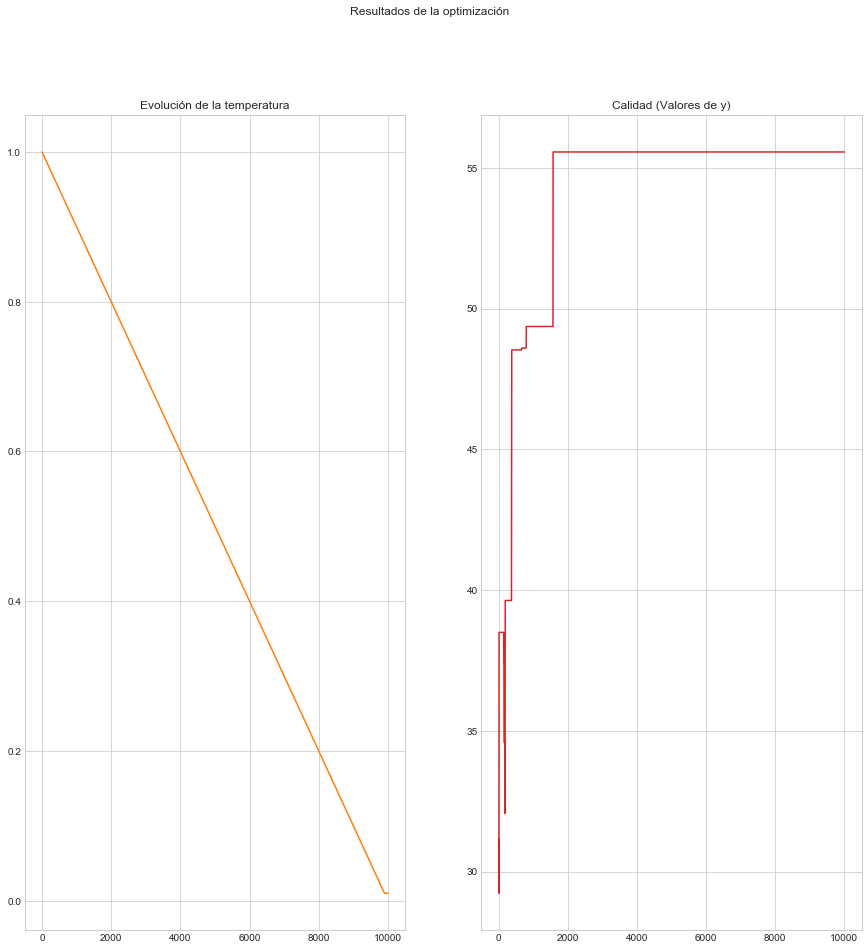

In [152]:
import graficos as gf
gf.plot_results(valores_y, valores_t,x)

#### Análisis de la solución obtenida

In [158]:
p_bets_sa = [4.71086679e-02, 2.78692033e-04, 3.98483308e-03, 6.12662835e-03, 1.60132554e-01, 2.02948107e-01, 5.79420518e-01]

In [159]:
LEAVE_WITH_MIN = 0 # Mínimo número de fichas con las que el jugador se retira
LEAVE_WITH_MAX = 150 # Máximo número de fichas con las que el jugador se retira
NUM_GAMES = 50 # Número máximo de partidas que puede jugar un jugador
INITIAL_CHIPS = 30 # Número de fichas iniciales con las que comienza a jugar
DAYS = 30 # Número de días que el jugador va a ir a jugara a la ruleta

In [160]:
matrix = tm.create_transition_matrix(LEAVE_WITH_MIN,LEAVE_WITH_MAX, bets, p_bets_sa)

Vamos a visualizar la matriz creada por medio de la libreria pandas y añadiendo un vector de filas y columnas que representan los estados del problema, es decir, las fichas que tiene el jugador en cada momento. 

In [161]:
df = pd.DataFrame(matrix)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.936069,0.000000,0.022918,0.000090,0.000000,0.000000,0.000646,0.000000,0.000000,0.000662,0.000000,0.000000,0.012984,0.000000,0.000000,0.000000,0.0,0.0,0.01097,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01566,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.936069,0.000000,0.022918,0.000090,0.000000,0.000000,0.000646,0.000000,0.000000,0.000662,0.000000,0.000000,0.012984,0.000000,0.000000,0.0,0.0,0.00000,0.01097,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.01566,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.936069,0.000000,0.022918,0.000090,0.000000,0.000000,0.000646,0.000000,0.000000,0.000662,0.000000,0.000000,0.012984,0.000000,0.0,0.0,0.00000,0.00000,0.01097,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.01566,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [162]:
simulation, chips, games = simulate(matrix, gambling_random,NUM_GAMES, INITIAL_CHIPS, DAYS)
df = create_df(chips, games)

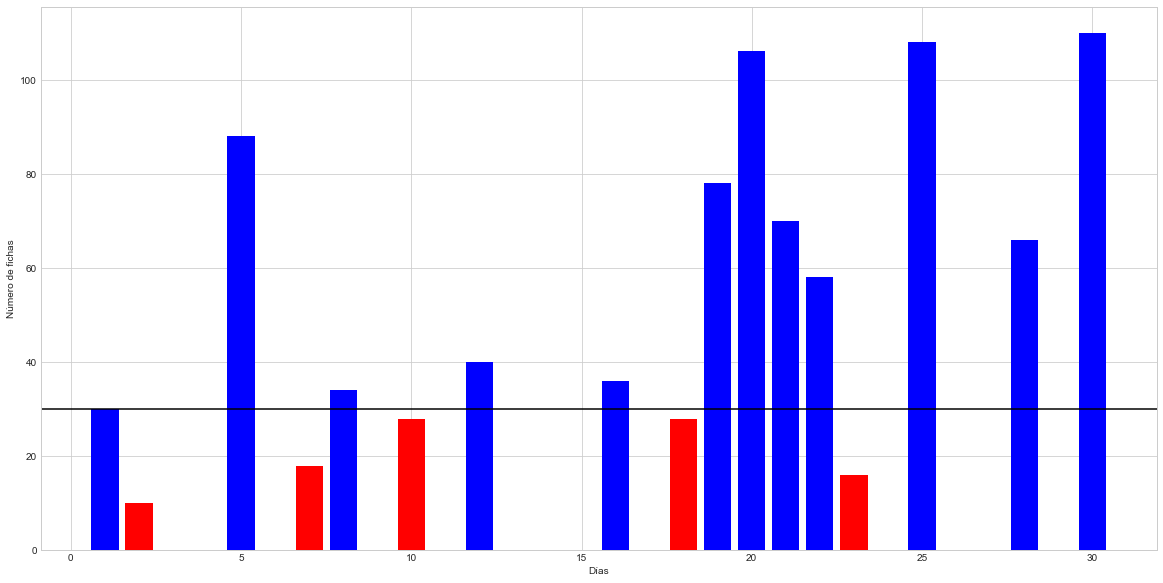

In [163]:
plot_bar_graph(df, INITIAL_CHIPS)

In [164]:
show_results(df, INITIAL_CHIPS, LEAVE_WITH_MAX)

Número de noches que el jugador perdió todas las fichas: 13
Porcentaje de noches que el jugador perdió todas las fichas: 43.33%
Número de noches que el jugador perdió fichas: 18
Porcentaje de noches que el jugador perdió fichas: 60.0%
Número de noches que el jugador salió igual del casino: 1
Porcentaje de noches que el jugador salió igual del casino: 3.33%
Número de noches que el jugador ganó fichas: 11
Porcentaje de noches que el jugador ganó fichas: 36.67%
Número de noches que el jugador se retiró alcanzando el máximo de fichas: 0
Porcentaje de noches que el jugador se retiró alcanzando el máximo de fichas: 0.0%


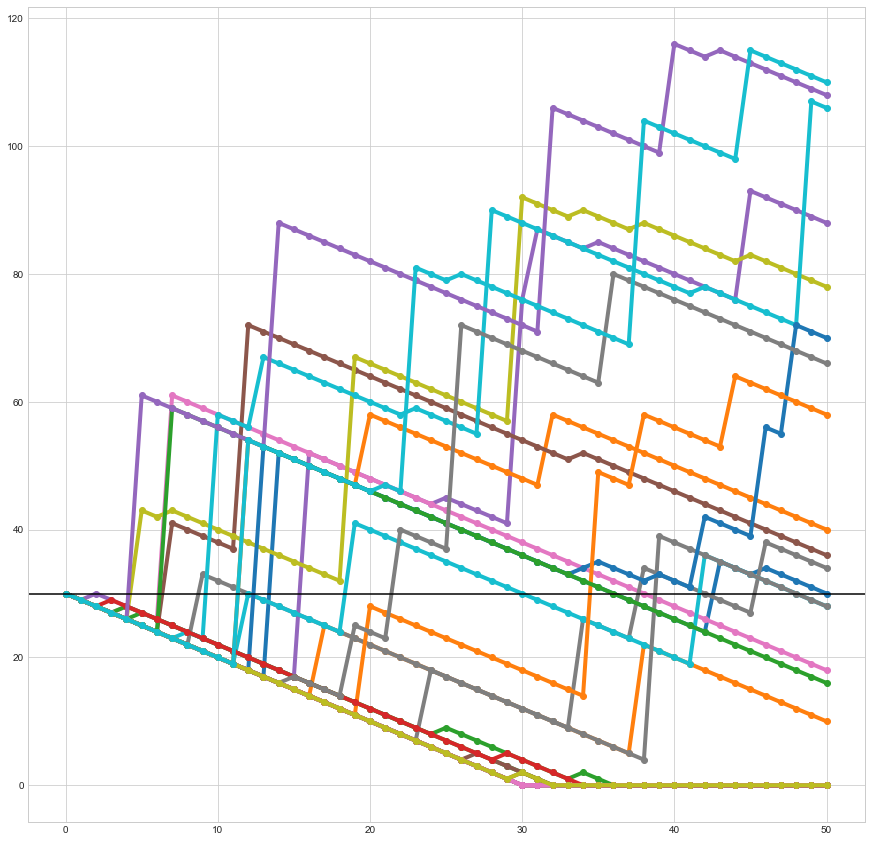

In [165]:
plot_chips_evolution(chips)

Por último, vamos a mostra rle histograma de frecuencia de la cantidad de fichas con las que le jugador es capaz de salir del casino a lo largo de un mes. 

(0, 176.6760709629107)

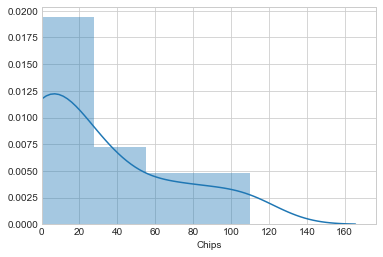

In [166]:
sns.distplot(df['Chips']);plt.xlim(0,None)

In [167]:
ruined = df[df['Chips'] == 0]
ruined

,Day,Chips,Games,Benefit,Improvement
2,3,0,32,-30,-1.0
3,4,0,30,-30,-1.0
5,6,0,32,-30,-1.0
8,9,0,30,-30,-1.0
10,11,0,30,-30,-1.0
12,13,0,36,-30,-1.0
13,14,0,30,-30,-1.0
14,15,0,30,-30,-1.0
16,17,0,30,-30,-1.0
23,24,0,34,-30,-1.0


In [168]:
"El jugador se ha arruinado "+ str(ruined.shape[0]) +" veces, jugando de media " + str(round(ruined["Games"].mean(),2)) + " días antes de arruinarse."

'El jugador se ha arruinado 13 veces, jugando de media 31.38 días antes de arruinarse.'

In [169]:
df.describe()

,Day,Chips,Games,Benefit,Improvement
count,30.000000,30.000000,30.000000,30.000000,30.000000
mean,15.500000,30.800000,41.933333,0.800000,0.026667
std,8.803408,37.226613,9.461112,37.226613,1.240887
min,1.000000,0.000000,30.000000,-30.000000,-1.000000
25%,8.250000,0.000000,32.000000,-30.000000,-1.000000
50%,15.500000,17.000000,50.000000,-13.000000,-0.433333
75%,22.750000,53.500000,50.000000,23.500000,0.783333
max,30.000000,110.000000,50.000000,80.000000,2.666667
